In [63]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

import skimage
import skimage.measure
import matplotlib.patches as mpatches

from scipy import ndimage
from skimage import morphology, util, filters

import tifffile


# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

### Load image stack

In [64]:
# load tiff stake with pims. Notice here I only have two channels, gfp and cy5
#Burst /Volumes/SL_2023/0313/droplet_different_low_MT_6_8_2_burst

frames = pims.ImageSequence('/Users/scliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_4/aster_connection/5min_no_merge/*.tif')




Frame([[ 828,  823,  960, ...,  862,  818,  813],
       [ 876,  926,  985, ...,  892,  963,  819],
       [ 858,  939,  908, ...,  911,  924,  943],
       ...,
       [1061, 1008, 1139, ..., 1150, 1050,  911],
       [ 960, 1155, 1067, ..., 1064,  988,  992],
       [1018,  916,  968, ..., 1028,  973,  872]], dtype=uint16)
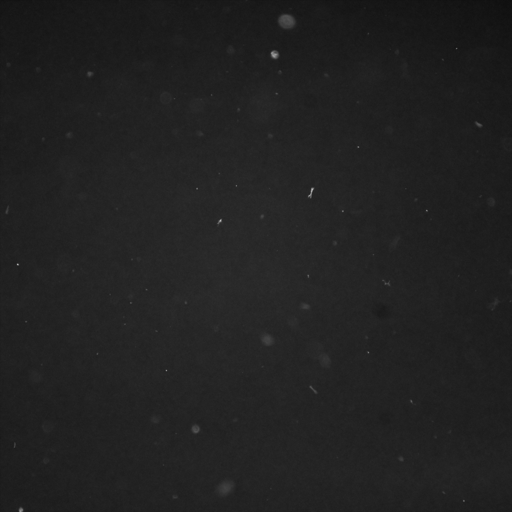

In [65]:
# only want the bf frame
bf_frames = frames[::2]
bf_frames[1]

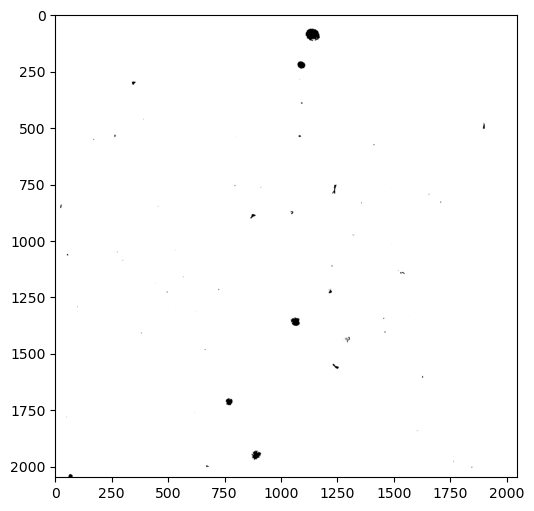

In [66]:
from skimage import filters, util
from scipy import ndimage
import numpy as np

def create_pipeline():
    frame_counter = {'count': 0}  # use a dict to make it mutable inside the nested function

    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        # Apply thresholds
        percentile = 99.3 if frame_counter['count'] < 29 else 99.99999  # adjust the percentile based on the frame number
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)

        # increment the frame counter
        frame_counter['count'] += 1

        return util.img_as_int(img)
    
    return preprocess_foam

preprocess_foam = create_pipeline()



frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[11]);

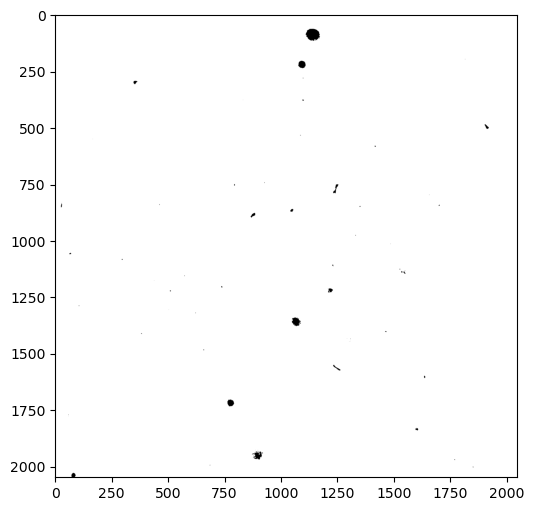

In [67]:
# First, create two separate pipelines for each percentile

def create_pipeline(percentile):
    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)
        return util.img_as_int(img)
    return preprocess_foam

# Then, process the first 30 frames with 99 percentile and the remaining frames with 99.95 percentile

preprocess_foam_994 = create_pipeline(99.4)
preprocess_foam_995 = create_pipeline(99.5)
preprocess_foam_9997 = create_pipeline(99.97)

frames_thresh_994 = preprocess_foam_994(bf_frames[:20])
frames_thresh_995 = preprocess_foam_995(bf_frames[20:30])
frames_thresh_9997 = preprocess_foam_9997(bf_frames[30:])

frames_thresh = np.concatenate((frames_thresh_994, frames_thresh_995, frames_thresh_9997), axis=0)

# Now, frames_thresh should contain all frames processed with the appropriate percentile
plt.imshow(frames_thresh[5]);


In [68]:
len(bf_frames)

100

Found 90 features


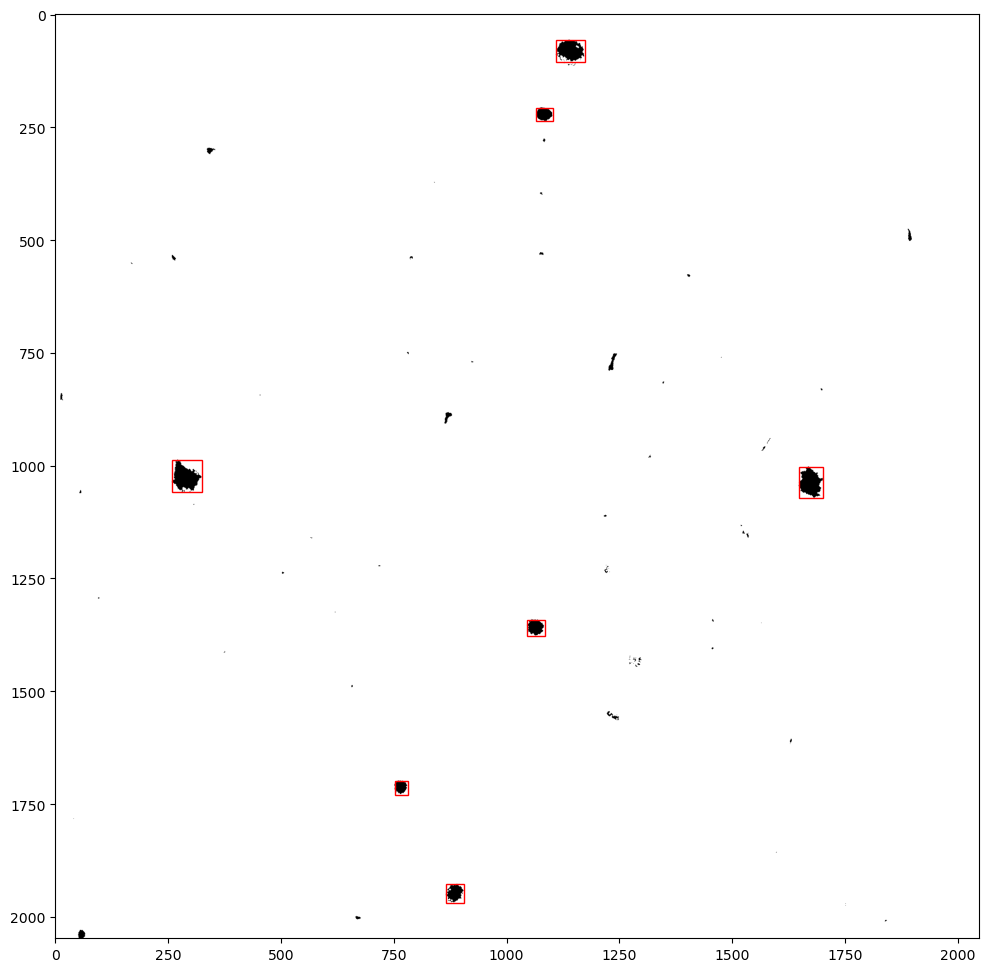

In [69]:
img_example = frames_thresh[18]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 300 or region.area > 8000:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 8000 and region.area < 300:
        continue


    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [70]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            200 <= region.area <= 5000 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 5000 and region.area < 200)
            )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


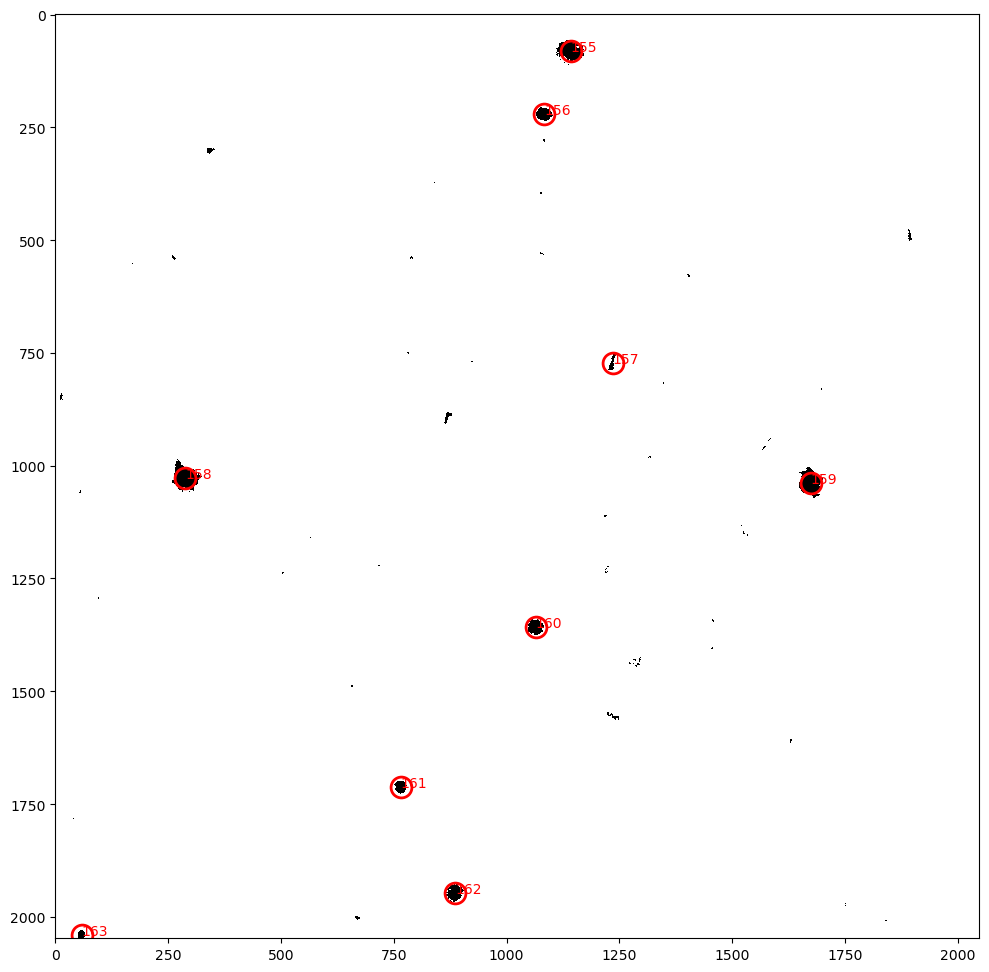

In [71]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(18, features, img_example)


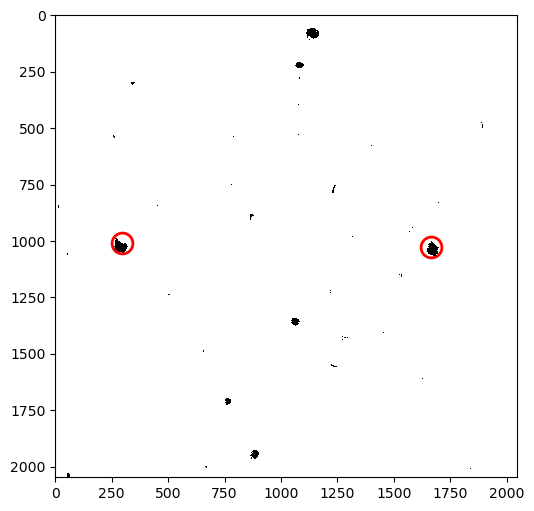

In [72]:
id_example = 50
tp.annotate(features[features.frame==(id_example+1)], img_example);


In [73]:
features

,y,x,frame
0,84.207945,1145.884070,0
1,216.039642,1100.273657,0
2,772.519355,1241.219355,0
3,1227.040741,1225.296296,0
4,1361.256198,1068.249115,0
...,...,...,...
365,1042.267123,1669.116438,95
366,1041.946309,1666.687919,96
367,1039.773463,1666.029126,97
368,1038.843260,1665.686520,98


Frame 99: 1 trajectories present.


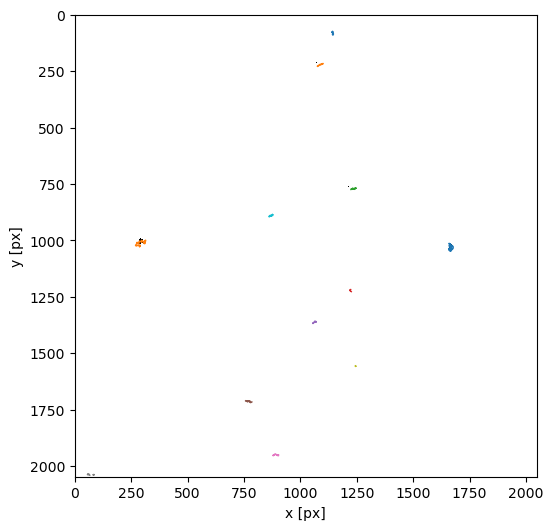

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [74]:
search_range = 40
t = tp.link_df(features, search_range, memory=40)
tp.plot_traj(t, superimpose=frames_thresh[50])

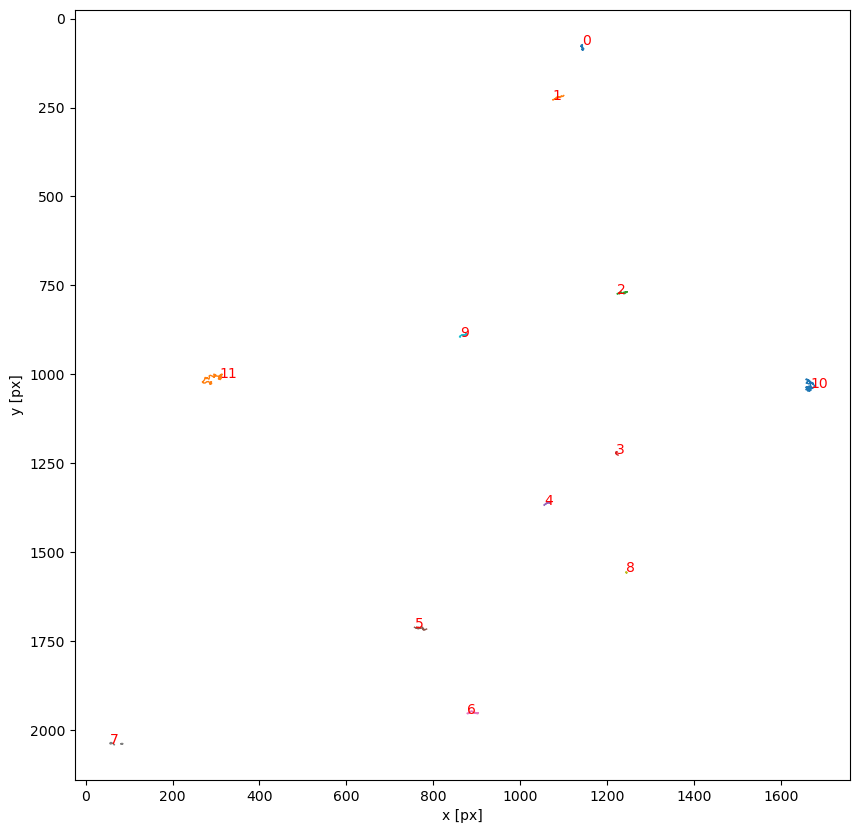

In [75]:
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Then you would use it like this:
plot_trajectory_with_labels(t)


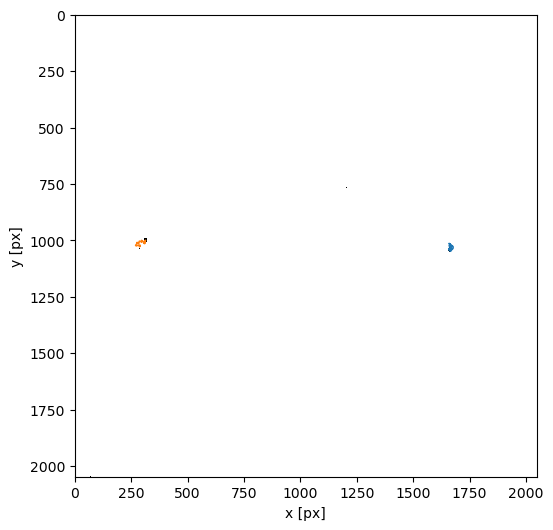

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [76]:
particle_ids = [10, 11]  # Replace with the IDs of the particles you want to plot
selected = t[t['particle'].isin(particle_ids)]
# Filter rows where particle is 24 and index is between 50 and 60
# Print the filtered dataframe
tp.plot_traj(selected, superimpose=frames_thresh[70])


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_10954/4097401154.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  particle_data = np.array(particle_data)


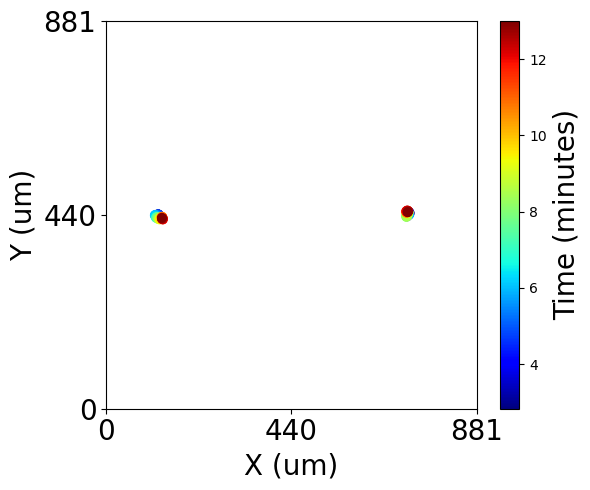

In [77]:
import matplotlib.ticker as ticker

# Ensure data is sorted by frame
selected_sorted = selected.sort_values(by='frame')

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = selected_sorted[selected_sorted['particle'] == particle_id]
    
    # Store x, y, and time data for current particle. Convert pixels to um.
    particle_data.append((particle['x'].values * 0.43, particle['y'].values * 0.43, particle['frame'].values * 10/60))
    
# Convert list of tuples to numpy array
particle_data = np.array(particle_data)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust as needed to get a square plot

# Loop through each particle and plot its trajectory
for i in range(len(particle_data)):
    sc = ax.scatter(particle_data[i, 0], particle_data[i, 1], c=particle_data[i, 2], cmap='jet')

# Invert y-axis and set plot limits
ax.set_xlim(0, 2048 * 0.43)
ax.set_ylim(0, 2048 * 0.43)
ax.tick_params(axis='both', labelsize=20)


# Set x and y ticks
ax.set_xticks([0, 2048 * 0.43 / 2, 2048 * 0.43])
ax.set_yticks([0, 2048 * 0.43 / 2, 2048 * 0.43])

formatter = ticker.FormatStrFormatter('%.0f')
# Apply the formatter to the x and y axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Set x and y labels
ax.set_xlabel('X (um)', fontsize=20)
ax.set_ylabel('Y (um)', fontsize=20)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Time (minutes)', fontsize=20)

plt.tight_layout()
plt.show()


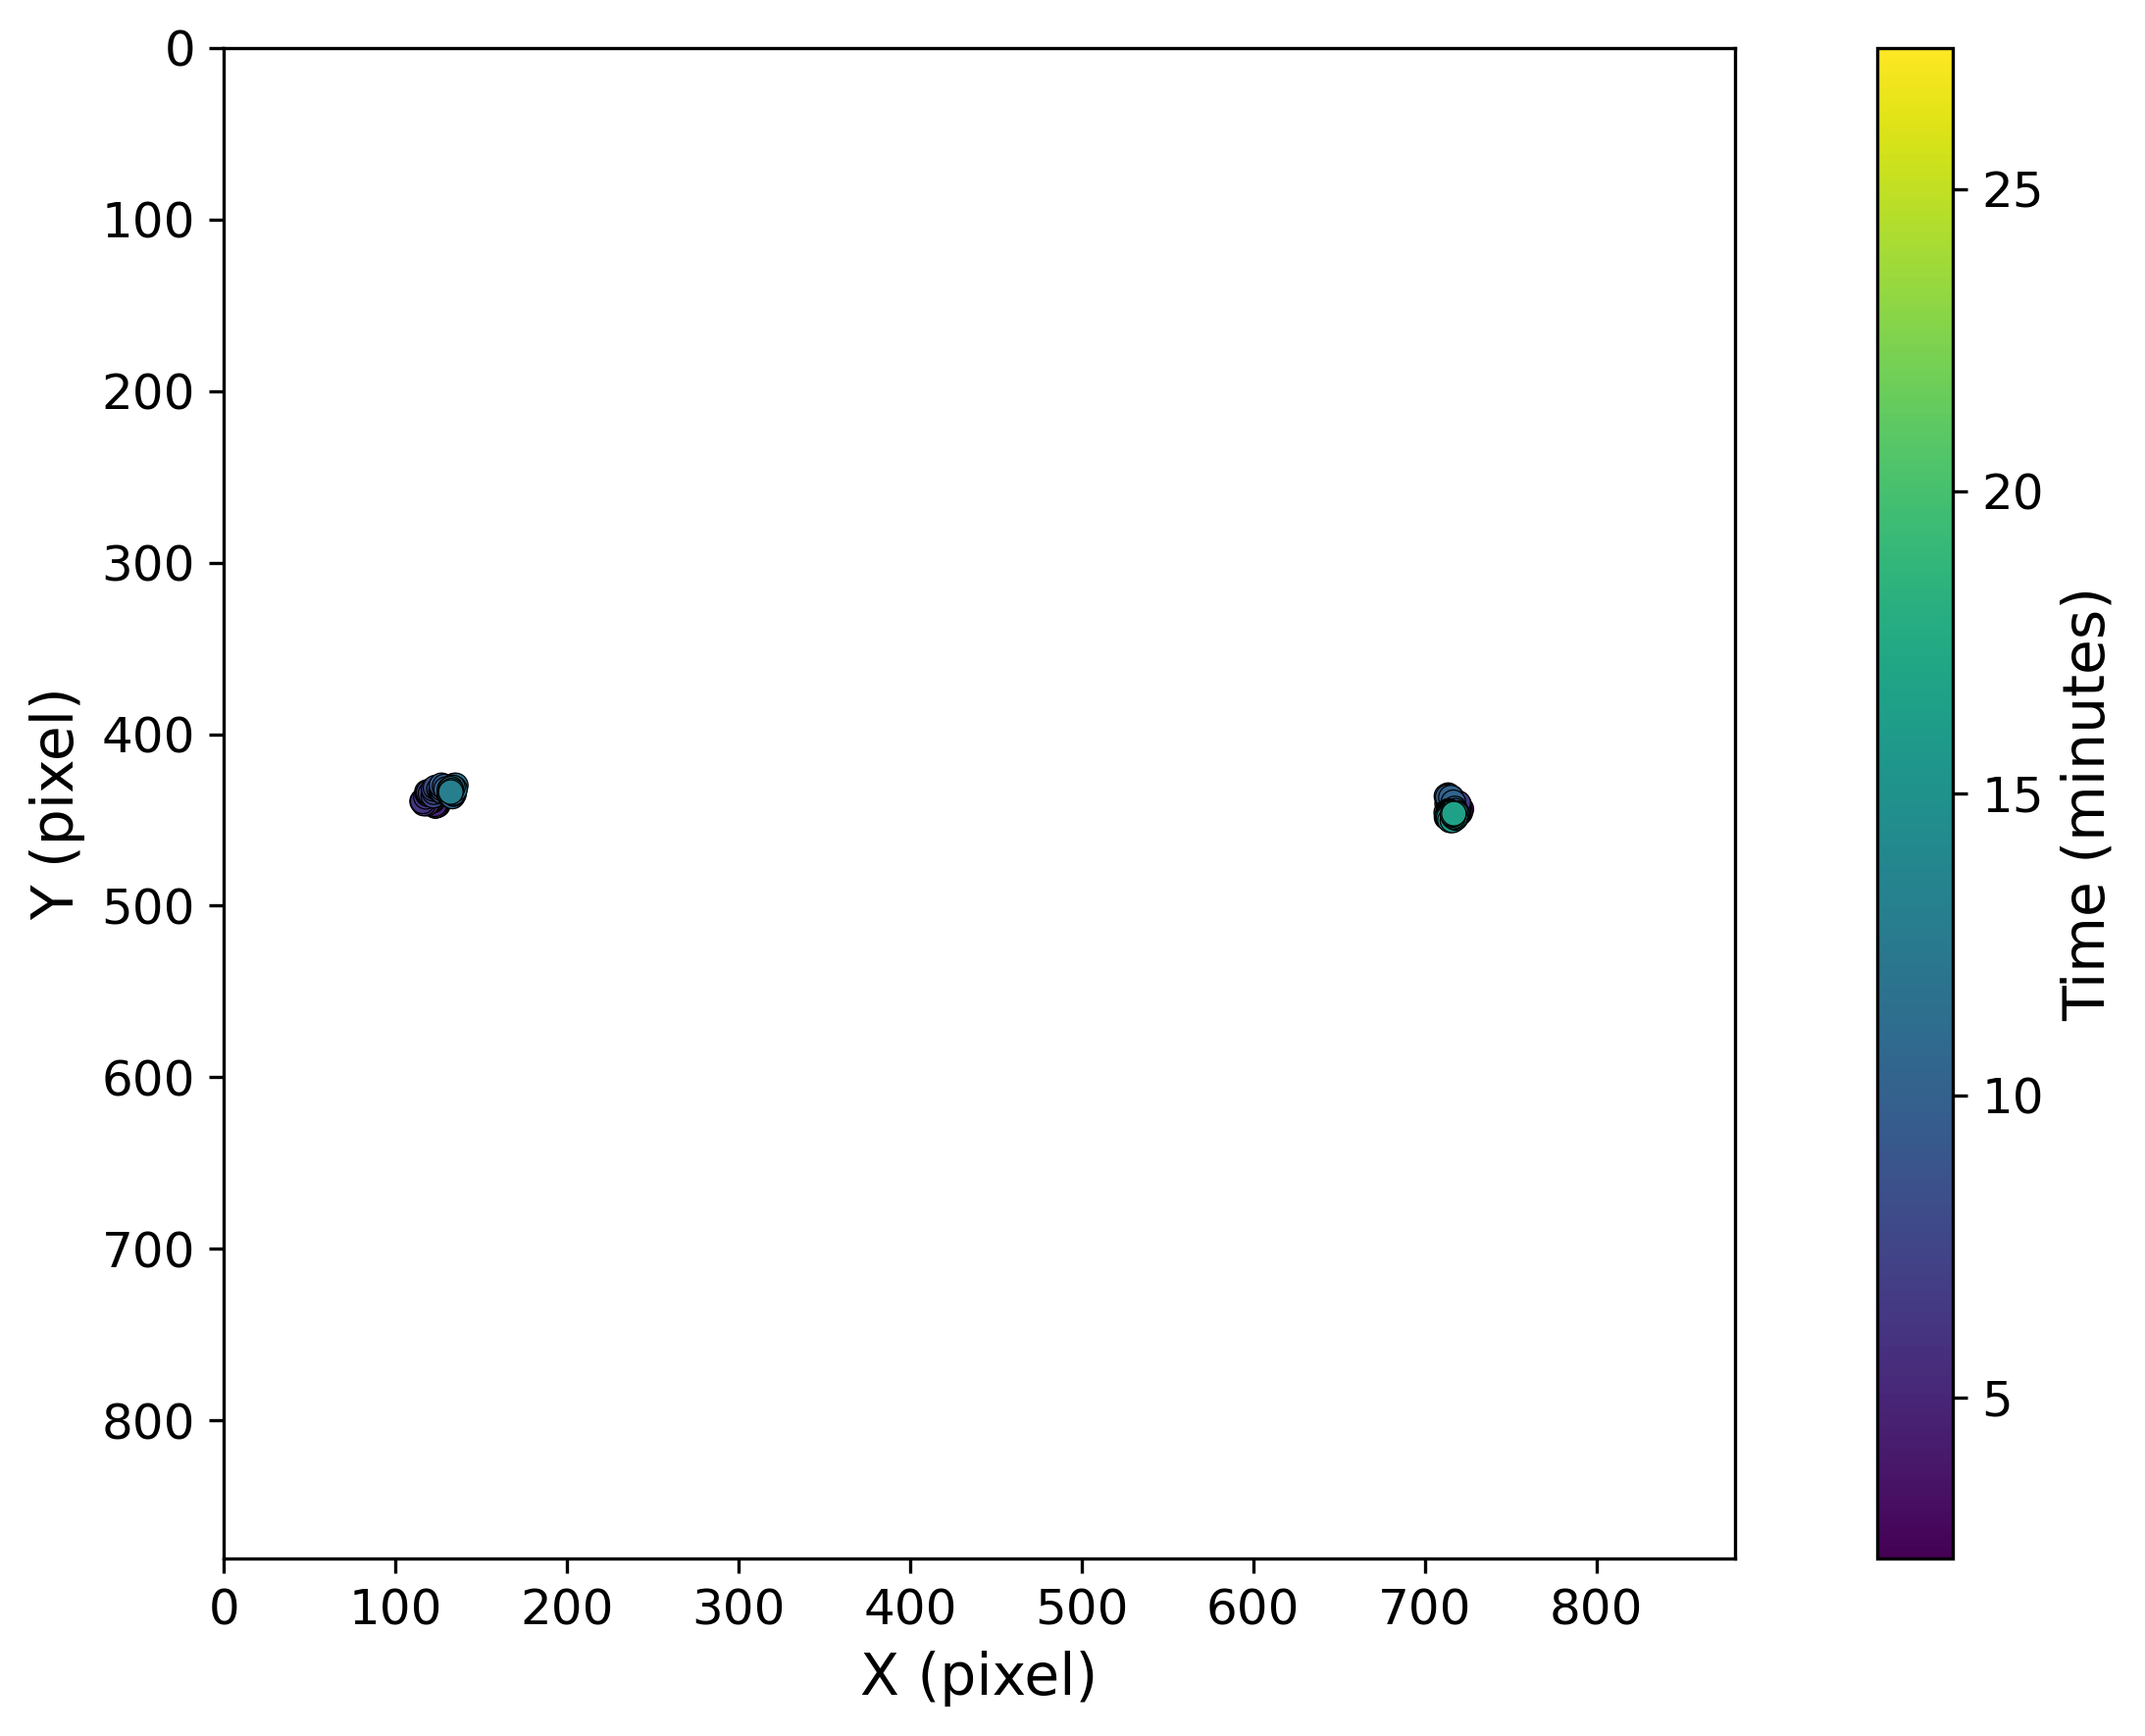

In [80]:
# Set a higher resolution for the figure
plt.figure(dpi=300)

# Define a clear font size for labels, ticks, and title
label_fontsize = 14
tick_fontsize = 12
title_fontsize = 16

# Use a different colormap if desired (e.g., "viridis" is perceptually uniform and colorblind-friendly)
cmap_choice = 'viridis'

# Loop through each particle and plot its trajectory
for particle in particle_data:
    x, y, frame_in_minutes = particle
    plt.scatter(x, y, c=frame_in_minutes, cmap=cmap_choice, vmin=np.min(t_filtered['frame'])*10/60, vmax=np.max(t_filtered['frame'])*10/60, edgecolor='k', linewidth=0.3)

# Add colorbar
cbar = plt.colorbar(label='Time (minutes)')
cbar.ax.tick_params(labelsize=tick_fontsize) 
cbar.set_label('Time (minutes)', size=label_fontsize)

# Invert y-axis and set plot limits
plt.gca().invert_yaxis()
plt.xlim(0, 2048 * 0.43)
plt.ylim(2048 * 0.43, 0)

# Set equal scaling for x and y axes
plt.gca().set_aspect('equal', adjustable='box')

# Setting tick parameters
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Set axis labels
plt.xlabel('X (pixel)', fontsize=label_fontsize)
plt.ylabel('Y (pixel)', fontsize=label_fontsize)

# Optionally, you can set a title
# plt.title('Particle Trajectories Over Time', fontsize=title_fontsize)

# Tight layout often improves the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [83]:
import numpy as np
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.models import ColorBar, LinearColorMapper, ColumnDataSource
from bokeh.layouts import column
from bokeh.transform import transform

# Activate inline plotting in Jupyter
output_notebook()

# Create a Bokeh figure
p = figure(plot_width=600, plot_height=600, tools="pan,reset,save,wheel_zoom")

# Define color mapper
color_mapper = LinearColorMapper(palette="Viridis256", low=np.min(t_filtered['frame']*10/60), high=np.max(t_filtered['frame']*10/60))

for particle in particle_data:
    x, y, frame = particle
    source = ColumnDataSource(data=dict(x=x, y=y, color=frame))
    p.scatter(x='x', y='y', source=source, size=8, color=transform('color', color_mapper))

# Add color bar to the right
color_bar = ColorBar(color_mapper=color_mapper, width=8, location=(0,0))
color_bar.title = 'Time (minutes)'
p.add_layout(color_bar, 'right')

# Adjust the view settings
p.y_range.flipped = True
p.x_range.start, p.x_range.end = 0, 2048 * 0.43
p.y_range.start, p.y_range.end = 0, 2048 * 0.43

# Set axis labels
p.xaxis.axis_label = "X (pixel)"
p.yaxis.axis_label = "Y (pixel)"

show(p)


Loading BokehJS ...

# Connecting Aster

Frame([[1006, 1144, 1039, ..., 1112, 1058, 1154],
       [1203, 1201, 1160, ..., 1131, 1194, 1142],
       [1173, 1193, 1254, ..., 1163, 1131, 1168],
       ...,
       [1287, 1350, 1391, ..., 1422, 1389, 1217],
       [1251, 1359, 1378, ..., 1402, 1446, 1310],
       [1249, 1295, 1268, ..., 1316, 1282, 1346]], dtype=uint16)
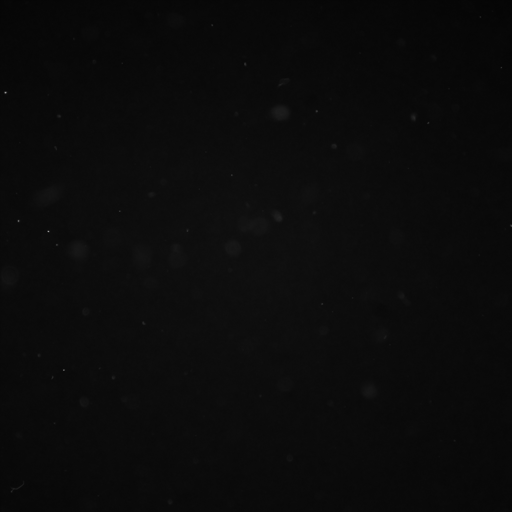

In [16]:
# load tiff stake with pims. Notice here I only have two channels, gfp and cy5
#Burst /Volumes/SL_2023/0313/droplet_different_low_MT_6_8_2_burst

frames = pims.ImageSequence('/Users/scliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_4/aster_connection/90min_merged/*.tif')
# only want the bf frame
bf_frames = frames[::2]
bf_frames[1]



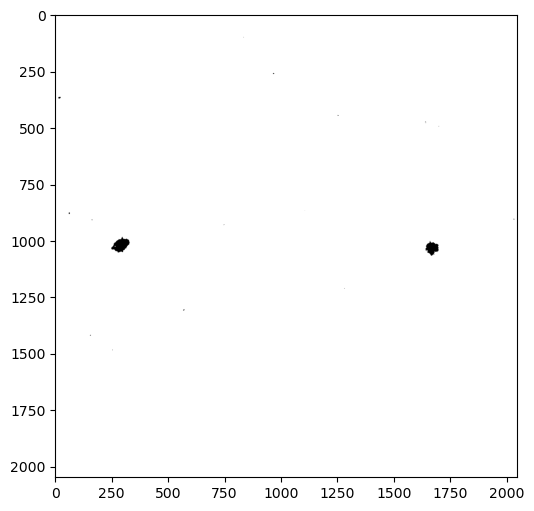

In [17]:
from skimage import filters, util
from scipy import ndimage
import numpy as np

def create_pipeline():
    frame_counter = {'count': 0}  # use a dict to make it mutable inside the nested function

    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        # Apply thresholds
        percentile = 99.8 if frame_counter['count'] < 29 else 99.8  # adjust the percentile based on the frame number
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)

        # increment the frame counter
        frame_counter['count'] += 1

        return util.img_as_int(img)
    
    return preprocess_foam

preprocess_foam = create_pipeline()



frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[20]);

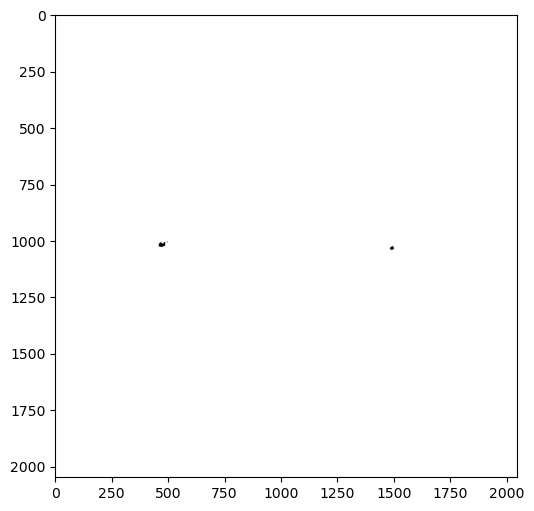

In [18]:
# First, create two separate pipelines for each percentile

def create_pipeline(percentile):
    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)
        return util.img_as_int(img)
    return preprocess_foam

# Then, process the first 30 frames with 99 percentile and the remaining frames with 99.95 percentile

preprocess_foam_994 = create_pipeline(99.4)
preprocess_foam_995 = create_pipeline(99.5)
preprocess_foam_9997 = create_pipeline(99.97)

frames_thresh_994 = preprocess_foam_994(bf_frames[:20])
frames_thresh_995 = preprocess_foam_995(bf_frames[20:30])
frames_thresh_9997 = preprocess_foam_9997(bf_frames[30:])

frames_thresh = np.concatenate((frames_thresh_994, frames_thresh_995, frames_thresh_9997), axis=0)

# Now, frames_thresh should contain all frames processed with the appropriate percentile
plt.imshow(frames_thresh[50]);


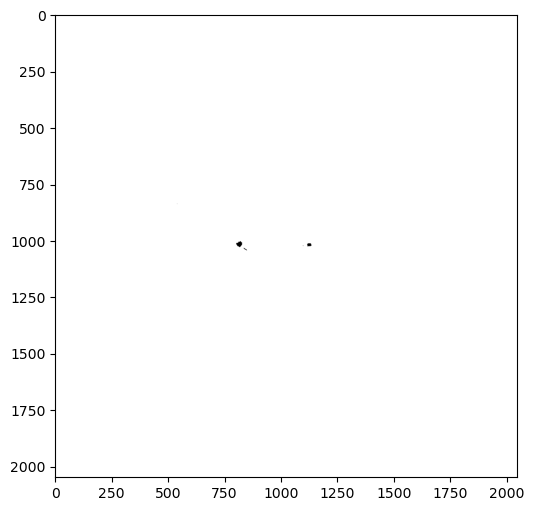

In [19]:
plt.imshow(frames_thresh[80]);

Found 86 features


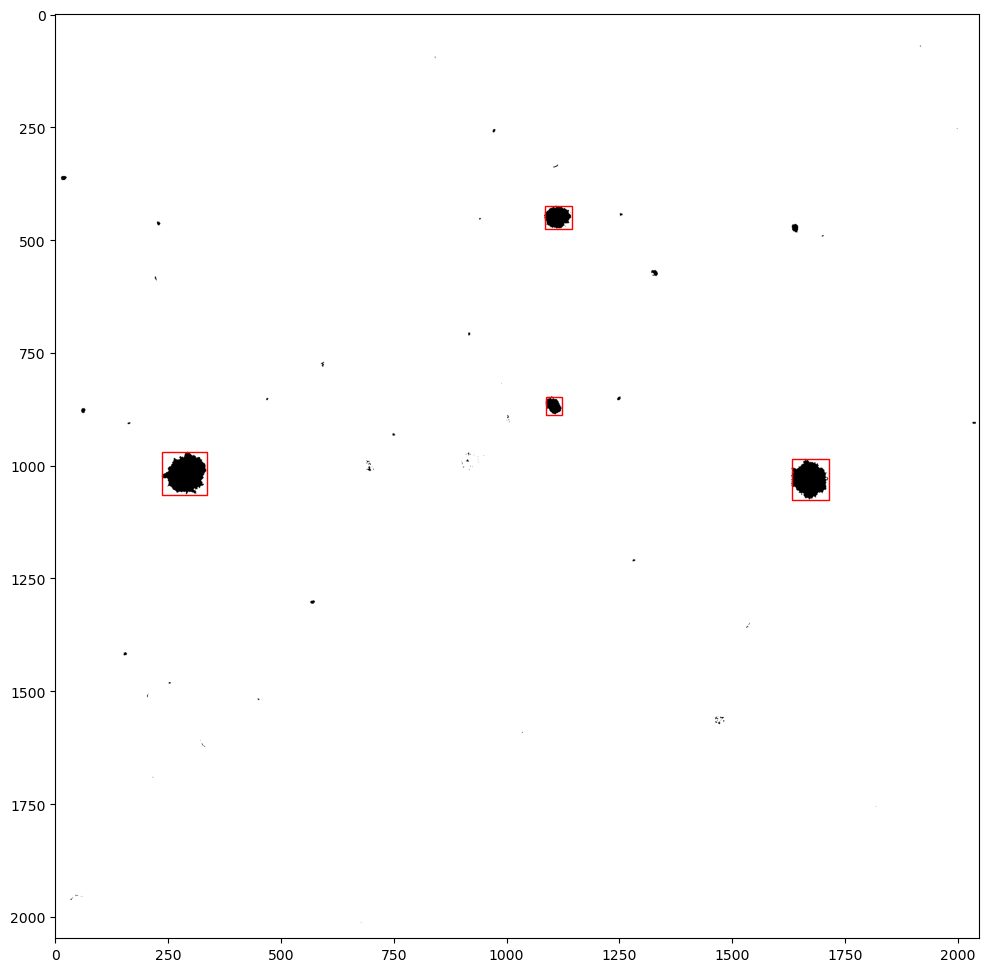

In [20]:
img_example = frames_thresh[18]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 300 or region.area > 8000:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 8000 and region.area < 300:
        continue


    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [21]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            200 <= region.area <= 5000 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 5000 and region.area < 200)
            )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


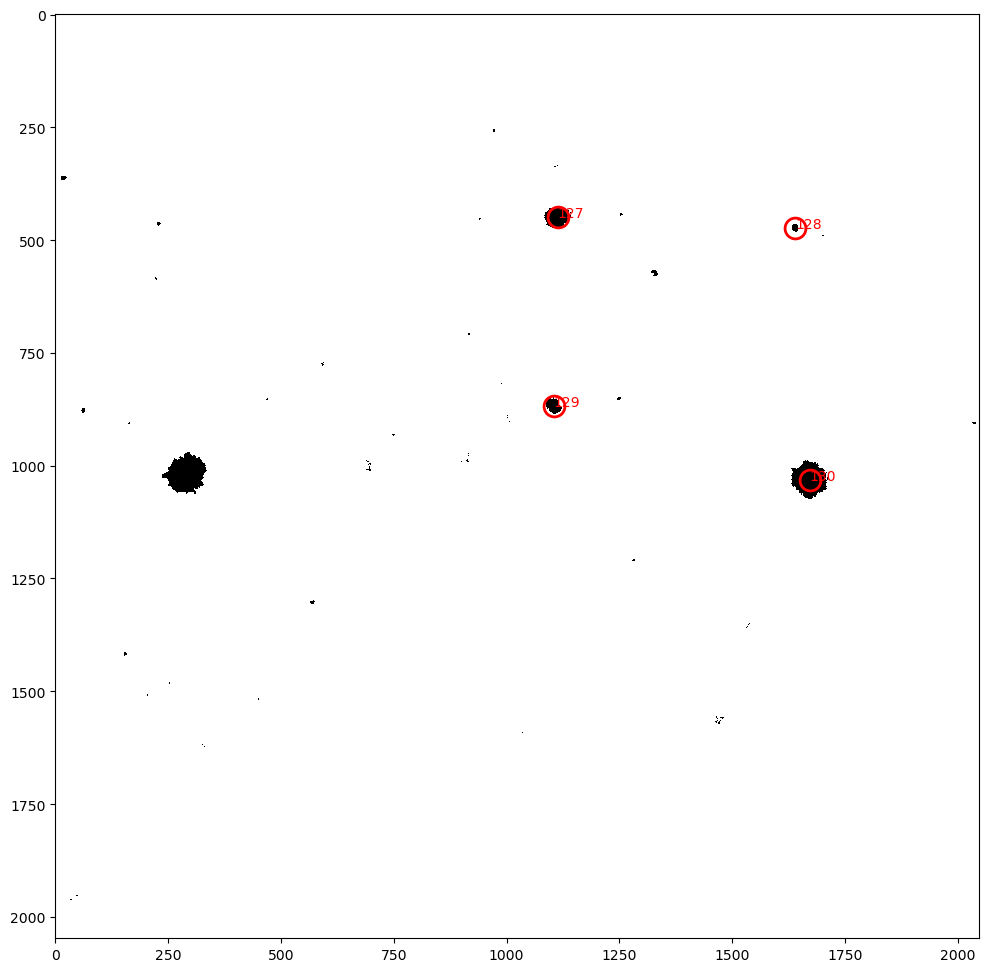

In [22]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(18, features, img_example)


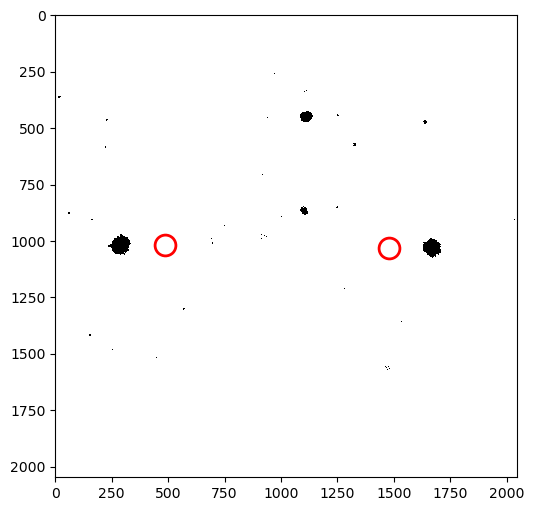

In [23]:
id_example = 50
tp.annotate(features[features.frame==(id_example+1)], img_example);


Frame 99: 2 trajectories present.


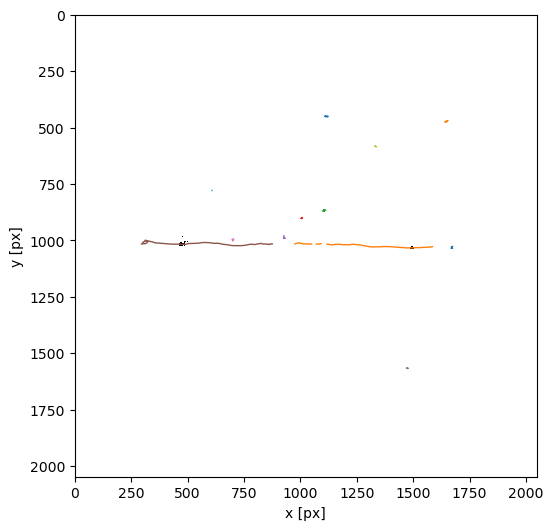

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [24]:
search_range = 40
t = tp.link_df(features, search_range, memory=40)
tp.plot_traj(t, superimpose=frames_thresh[50])

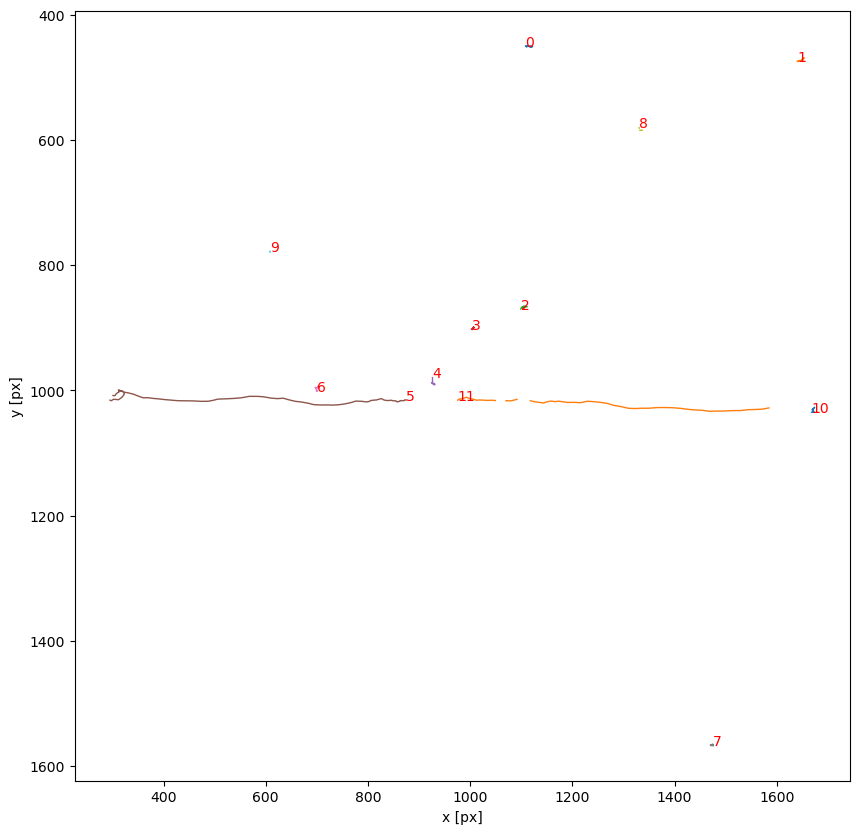

In [25]:
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Then you would use it like this:
plot_trajectory_with_labels(t)


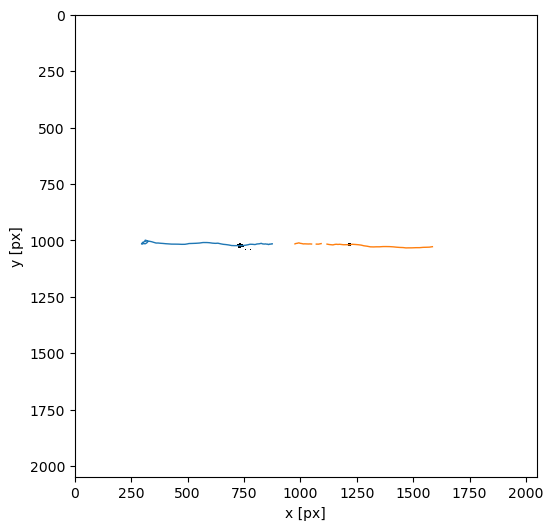

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [26]:
particle_ids = [5, 11]  # Replace with the IDs of the particles you want to plot
selected = t[t['particle'].isin(particle_ids)]
# Filter rows where particle is 24 and index is between 50 and 60
# Print the filtered dataframe
tp.plot_traj(selected, superimpose=frames_thresh[70])


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_10954/4097401154.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  particle_data = np.array(particle_data)


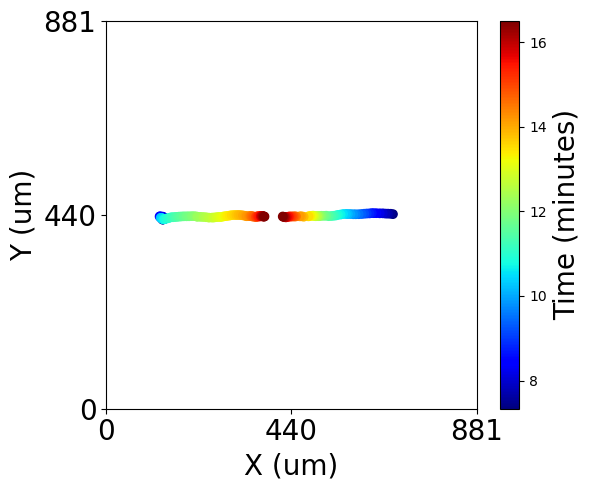

In [27]:
import matplotlib.ticker as ticker

# Ensure data is sorted by frame
selected_sorted = selected.sort_values(by='frame')

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = selected_sorted[selected_sorted['particle'] == particle_id]
    
    # Store x, y, and time data for current particle. Convert pixels to um.
    particle_data.append((particle['x'].values * 0.43, particle['y'].values * 0.43, particle['frame'].values * 10/60))
    
# Convert list of tuples to numpy array
particle_data = np.array(particle_data)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust as needed to get a square plot

# Loop through each particle and plot its trajectory
for i in range(len(particle_data)):
    sc = ax.scatter(particle_data[i, 0], particle_data[i, 1], c=particle_data[i, 2], cmap='jet')

# Invert y-axis and set plot limits
ax.set_xlim(0, 2048 * 0.43)
ax.set_ylim(0, 2048 * 0.43)
ax.tick_params(axis='both', labelsize=20)


# Set x and y ticks
ax.set_xticks([0, 2048 * 0.43 / 2, 2048 * 0.43])
ax.set_yticks([0, 2048 * 0.43 / 2, 2048 * 0.43])

formatter = ticker.FormatStrFormatter('%.0f')
# Apply the formatter to the x and y axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Set x and y labels
ax.set_xlabel('X (um)', fontsize=20)
ax.set_ylabel('Y (um)', fontsize=20)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Time (minutes)', fontsize=20)

plt.tight_layout()
plt.show()


# Moving aster

Frame([[728, 747, 787, ..., 680, 693, 712],
       [761, 846, 840, ..., 838, 725, 686],
       [769, 795, 875, ..., 719, 756, 704],
       ...,
       [813, 796, 816, ..., 938, 823, 841],
       [822, 825, 802, ..., 869, 833, 887],
       [691, 787, 763, ..., 848, 747, 776]], dtype=uint16)
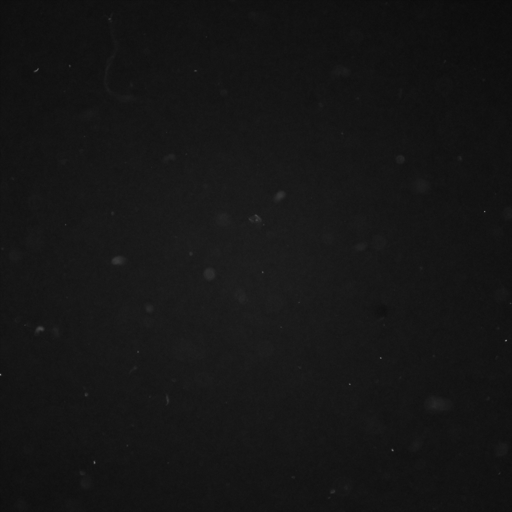

In [28]:
frames = pims.ImageSequence('/Users/scliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_4/aster_move/global/*.tif')
# only want the bf frame
bf_frames = frames[::2]
bf_frames[1]

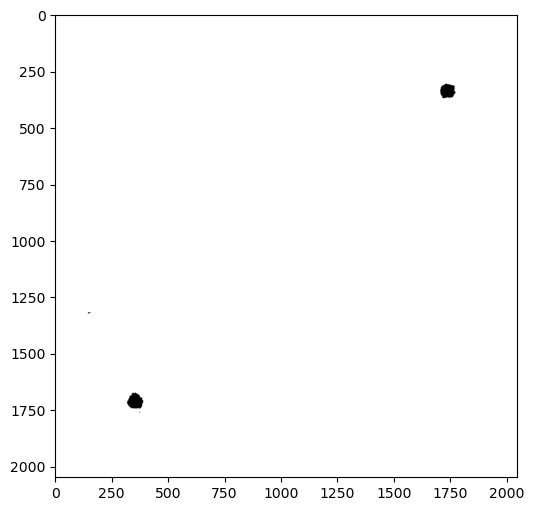

In [29]:
from skimage import filters, util
from scipy import ndimage
import numpy as np

def create_pipeline():
    frame_counter = {'count': 0}  # use a dict to make it mutable inside the nested function

    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        # Apply thresholds
        percentile = 99.8 if frame_counter['count'] < 29 else 99.8  # adjust the percentile based on the frame number
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)

        # increment the frame counter
        frame_counter['count'] += 1

        return util.img_as_int(img)
    
    return preprocess_foam

preprocess_foam = create_pipeline()



frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[20]);

In [30]:
import ipywidgets as widgets
from IPython.display import display

def display_frame(i):
    plt.imshow(frames_thresh[i])
    plt.show()

# Create a slider to select frame number
slider = widgets.IntSlider(value=0, min=0, max=len(frames_thresh) - 1, step=1, description='Frame:')

# Interactively display the frame based on the slider
widgets.interactive(display_frame, i=slider)

interactive(children=(IntSlider(value=0, description='Frame:', max=324), Output()), _dom_classes=('widget-inte…

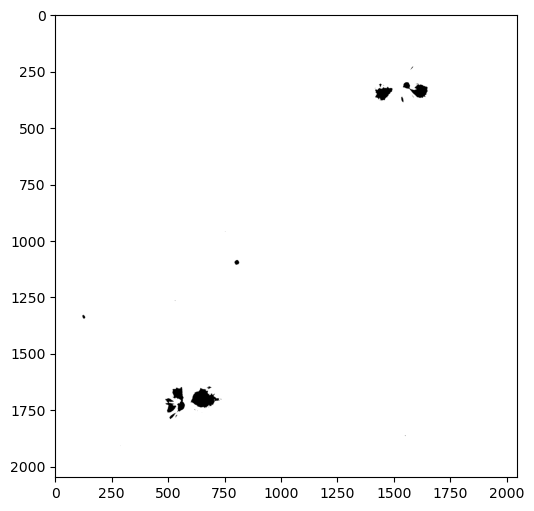

In [31]:
# First, create two separate pipelines for each percentile

def create_pipeline(percentile):
    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)
        return util.img_as_int(img)
    return preprocess_foam

# Then, process the first 30 frames with 99 percentile and the remaining frames with 99.95 percentile

preprocess_foam= create_pipeline(99.8)


frames_thresh= preprocess_foam_994(bf_frames)

# Now, frames_thresh should contain all frames processed with the appropriate percentile
plt.imshow(frames_thresh[50]);


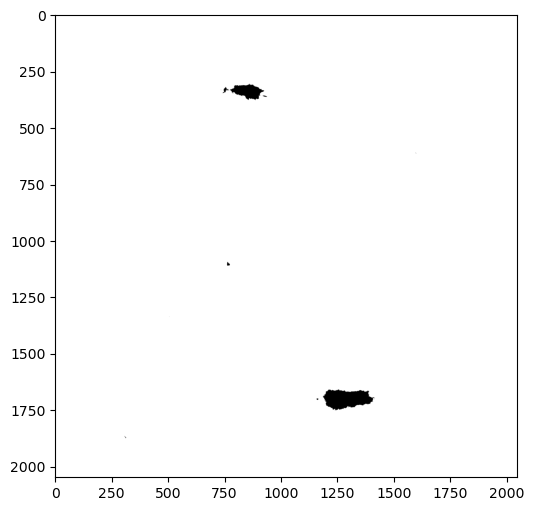

In [32]:
plt.imshow(frames_thresh[90]);


Found 24 features


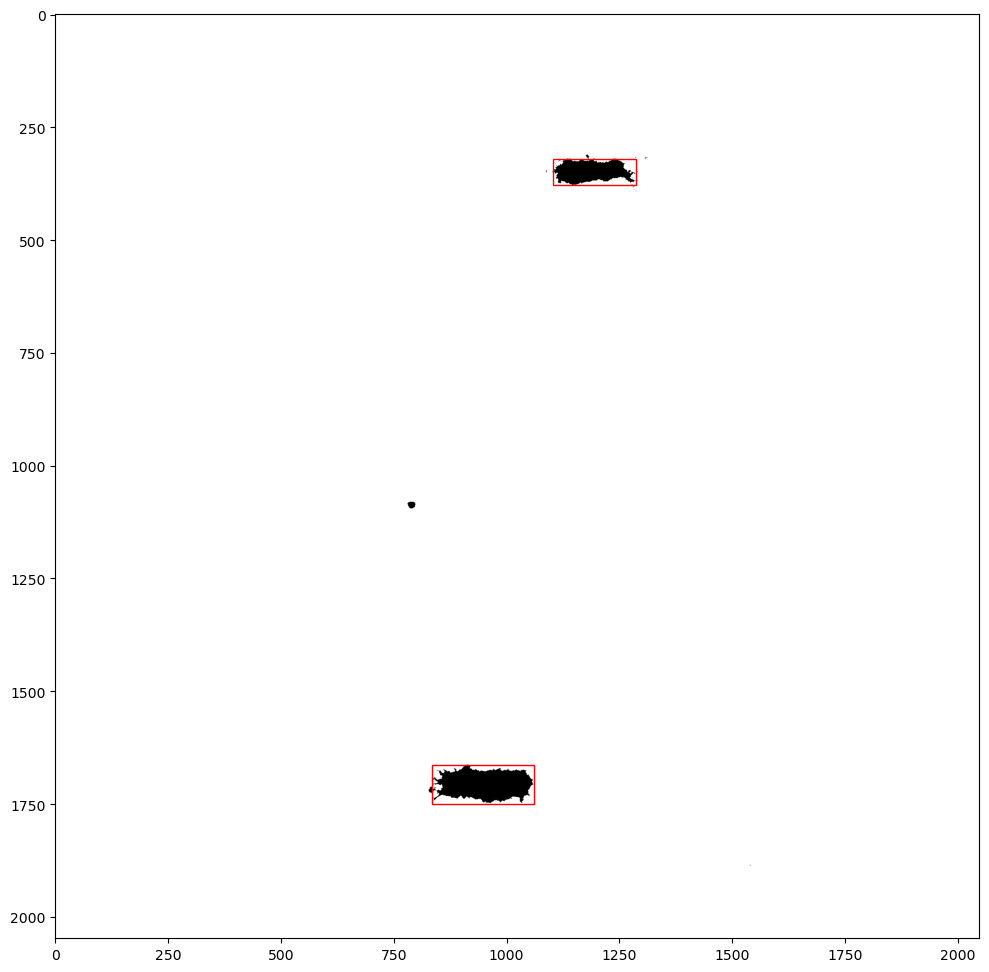

In [33]:
img_example = frames_thresh[70]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas|
    if region.area < 1000 or region.area > 15000:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 15000 and region.area < 1000:
        continue


    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [34]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            1000 <= region.area <= 15000 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 15000 and region.area < 1000)
            )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


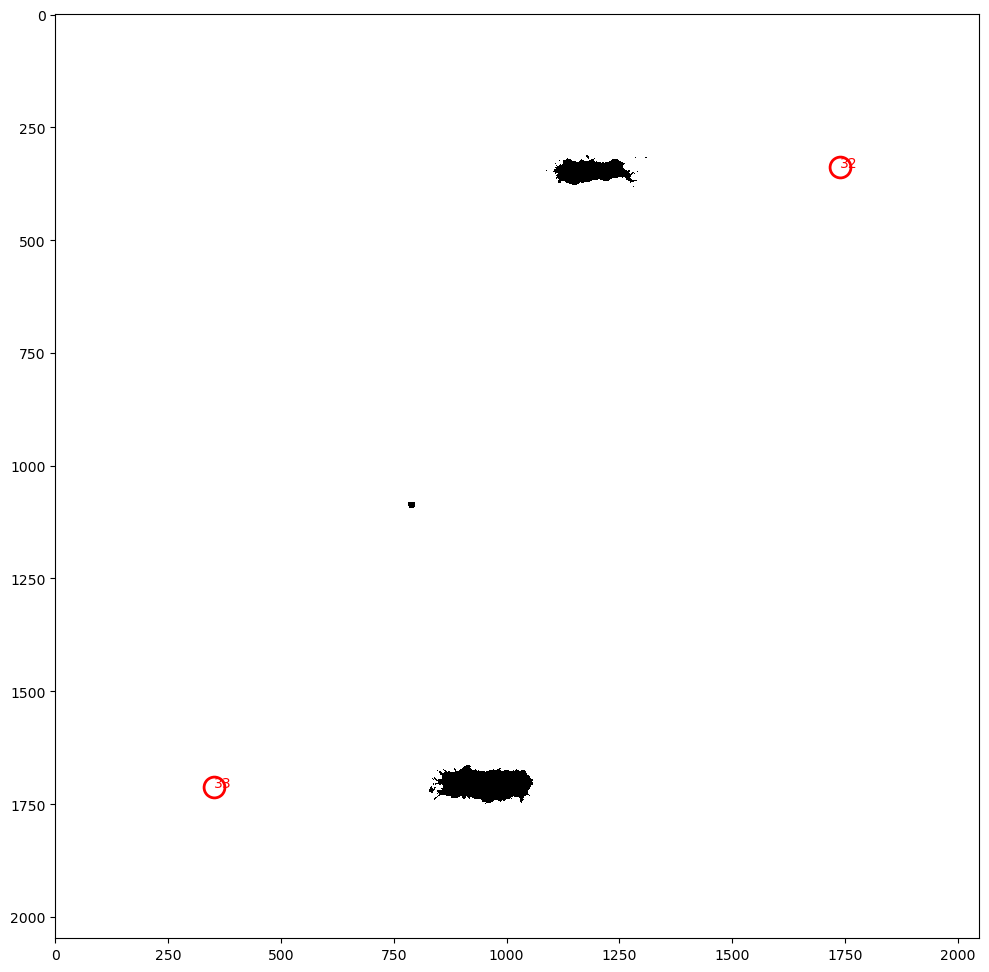

In [35]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(18, features, img_example)


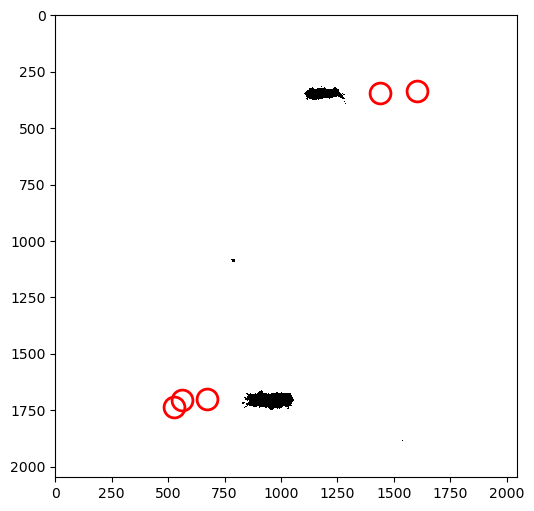

In [36]:
id_example = 50
tp.annotate(features[features.frame==(id_example+1)], img_example);


Frame 324: 3 trajectories present.


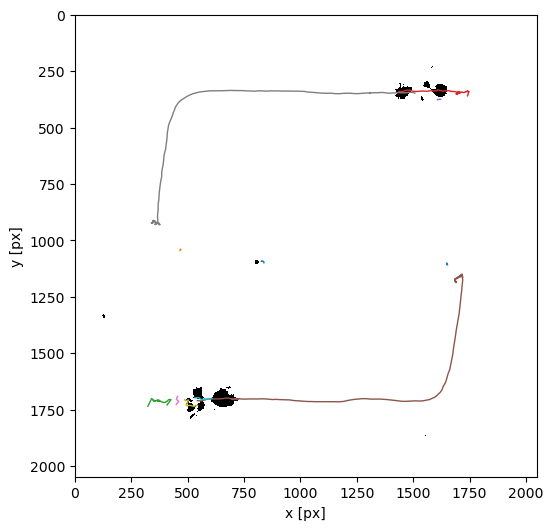

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [37]:
search_range = 40
t = tp.link_df(features, search_range, memory=100)
tp.plot_traj(t, superimpose=frames_thresh[50])

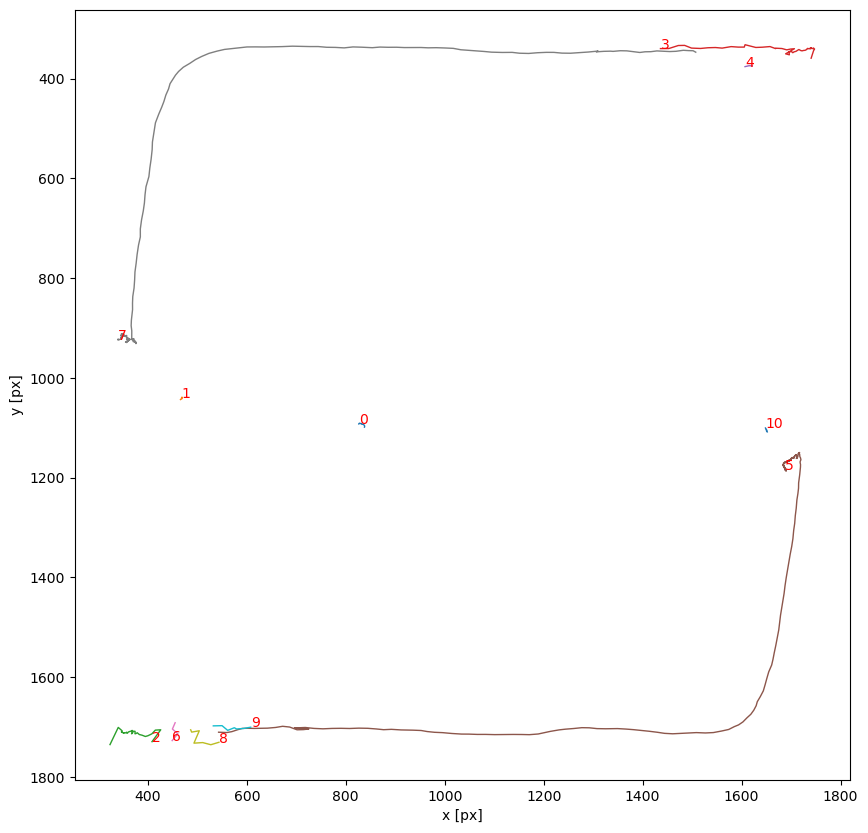

In [38]:
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Then you would use it like this:
plot_trajectory_with_labels(t)


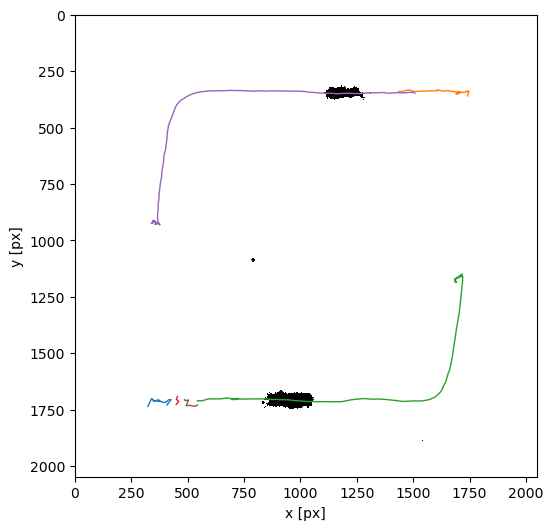

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [39]:
particle_ids = [3, 7, 2, 6, 8, 5]  # Replace with the IDs of the particles you want to plot
selected = t[t['particle'].isin(particle_ids)]
# Filter rows where particle is 24 and index is between 50 and 60
# Print the filtered dataframe
tp.plot_traj(selected, superimpose=frames_thresh[70])


In [40]:
selected

,y,x,frame,particle
14,1735.234375,323.504596,8,2
15,1700.812754,340.168863,9,2
16,359.255639,1740.449517,10,3
17,1707.580483,347.986612,10,2
19,1709.880371,346.508125,11,2
...,...,...,...,...
688,1185.773913,1689.187648,322,5
689,923.074088,339.291629,323,7
691,1185.075114,1688.045266,323,5
692,923.353860,339.506812,324,7


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_10954/4097401154.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  particle_data = np.array(particle_data)


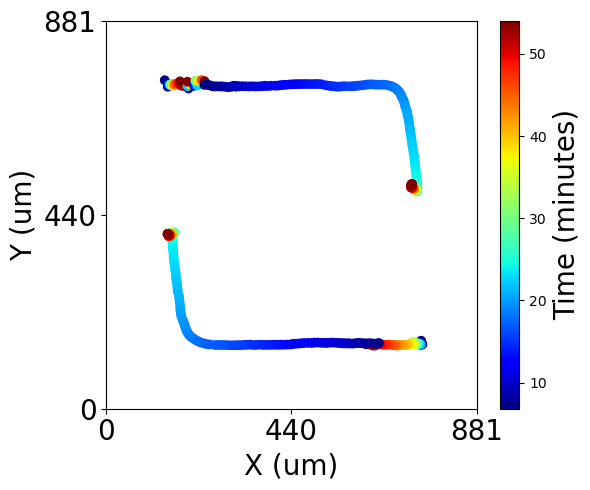

In [41]:
# Ensure data is sorted by frame
selected_sorted = selected.sort_values(by='frame')

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = selected_sorted[selected_sorted['particle'] == particle_id]
    
    # Store x, y, and time data for current particle. Convert pixels to um.
    particle_data.append((particle['x'].values * 0.43, particle['y'].values * 0.43, particle['frame'].values * 10/60))
    
# Convert list of tuples to numpy array
particle_data = np.array(particle_data)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust as needed to get a square plot

# Loop through each particle and plot its trajectory
for i in range(len(particle_data)):
    sc = ax.scatter(particle_data[i, 0], particle_data[i, 1], c=particle_data[i, 2], cmap='jet')

# Invert y-axis and set plot limits
ax.set_xlim(0, 2048 * 0.43)
ax.set_ylim(0, 2048 * 0.43)
ax.tick_params(axis='both', labelsize=20)


# Set x and y ticks
ax.set_xticks([0, 2048 * 0.43 / 2, 2048 * 0.43])
ax.set_yticks([0, 2048 * 0.43 / 2, 2048 * 0.43])

formatter = ticker.FormatStrFormatter('%.0f')
# Apply the formatter to the x and y axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Set x and y labels
ax.set_xlabel('X (um)', fontsize=20)
ax.set_ylabel('Y (um)', fontsize=20)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Time (minutes)', fontsize=20)

plt.tight_layout()
plt.show()


In [42]:
# Get unique particle IDs

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = t[t['particle'] == particle_id]
    
    # Store x, y, and frame data for current particle
    particle_data.append((particle['x'].values, particle['y'].values, particle['frame'].values))

# Check the particle_data
for i, data in enumerate(particle_data):
    print(f"Particle ID: {particle_ids[i]}, x: {data[0]}, y: {data[1]}, frame: {data[2]}")


Particle ID: 3, x: [1740.44951665 1745.37116212 1747.35331717 1745.82811111 1745.47283105
 1742.3625015  1741.13767383 1738.89042887 1738.56067609 1739.24627451
 1740.34519051 1739.91091197 1739.56358114 1738.72034233 1736.43380909
 1733.33730211 1731.68085106 1731.82001317 1728.16802132 1725.56432316
 1722.18900714 1720.14648074 1719.96764381 1715.61989586 1709.80180673
 1705.88952303 1703.42955326 1700.9782516  1695.77033837 1696.41248551
 1688.91155204 1706.68002764 1698.63471753 1691.21755823 1681.38987474
 1668.98900804 1668.53855959 1657.32929005 1641.75485514 1628.62914769
 1606.94979196 1605.28194587 1593.20445562 1578.79008397 1560.53527981
 1547.05871475 1531.94497249 1517.         1498.71882353 1484.80857428
 1472.09912536 1452.80310881 1435.96637998], y: [359.2556391  344.13012912 340.78598193 340.20122222 338.76929224
 340.12123395 338.96346397 339.85133368 339.07130596 340.21594771
 338.34918732 338.46586716 339.05242308 339.40394997 340.50923137
 339.54481225 341.0141411

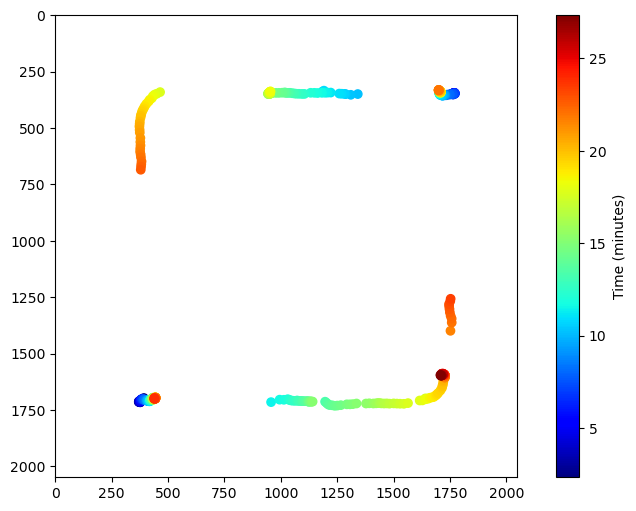

In [62]:
import numpy as np

# Filter dataframe for first 165 frames
t_filtered = t[t['frame'] < 165]

# Get unique particle IDs

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = t_filtered[t_filtered['particle'] == particle_id]
    
    # Store x, y, and frame data for current particle
    particle_data.append((particle['x'].values, particle['y'].values, particle['frame'].values*10/60))

# Loop through each particle and plot its trajectory
for particle in particle_data:
    x, y, frame = particle
    
    # Plot with colormap normalization
    plt.scatter(x, y, c=frame, cmap='jet', vmin=np.min(t_filtered['frame']*10/60), vmax=np.max(t_filtered['frame']*10/60))

plt.colorbar(label='Time (minutes)')

# Invert y-axis and set plot limits
plt.gca().invert_yaxis()
plt.xlim(0, 2048)
plt.ylim(2048, 0)

# Set equal scaling for x and y axes
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


# Local moving

Frame([[566, 651, 623, ..., 615, 590, 565],
       [680, 712, 688, ..., 691, 625, 650],
       [720, 729, 676, ..., 707, 722, 688],
       ...,
       [640, 707, 735, ..., 675, 705, 697],
       [661, 692, 666, ..., 778, 726, 695],
       [663, 665, 737, ..., 700, 691, 669]], dtype=uint16)
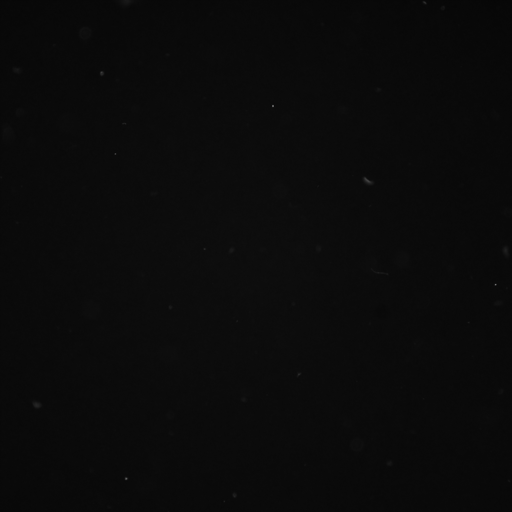

In [44]:
frames = pims.ImageSequence('/Users/scliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_4/aster_move/local/*.tif')
# only want the bf frame
bf_frames = frames[::2]
bf_frames[1]

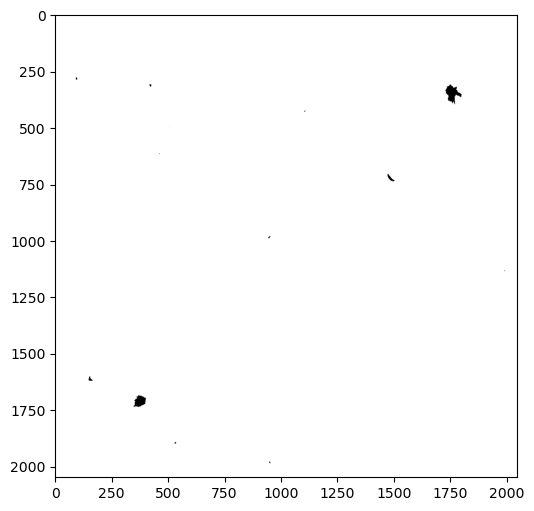

In [45]:
def create_pipeline():
    frame_counter = {'count': 0}  # use a dict to make it mutable inside the nested function

    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        # Apply thresholds
        percentile = 99.8 if frame_counter['count'] < 29 else 99.8  # adjust the percentile based on the frame number
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)

        # increment the frame counter
        frame_counter['count'] += 1

        return util.img_as_int(img)
    
    return preprocess_foam

preprocess_foam = create_pipeline()



frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[20]);

In [46]:
def display_frame(i):
    plt.imshow(frames_thresh[i])
    plt.show()

# Create a slider to select frame number
slider = widgets.IntSlider(value=0, min=0, max=len(frames_thresh) - 1, step=1, description='Frame:')

# Interactively display the frame based on the slider
widgets.interactive(display_frame, i=slider)

interactive(children=(IntSlider(value=0, description='Frame:', max=223), Output()), _dom_classes=('widget-inte…

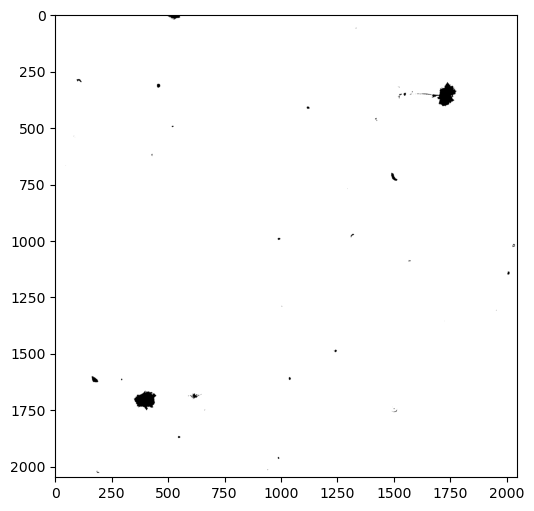

In [47]:
# First, create two separate pipelines for each percentile

def create_pipeline(percentile):
    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)
        return util.img_as_int(img)
    return preprocess_foam

# Then, process the first 30 frames with 99 percentile and the remaining frames with 99.95 percentile

preprocess_foam= create_pipeline(99.8)


frames_thresh= preprocess_foam_994(bf_frames)

# Now, frames_thresh should contain all frames processed with the appropriate percentile
plt.imshow(frames_thresh[50]);


Found 77 features


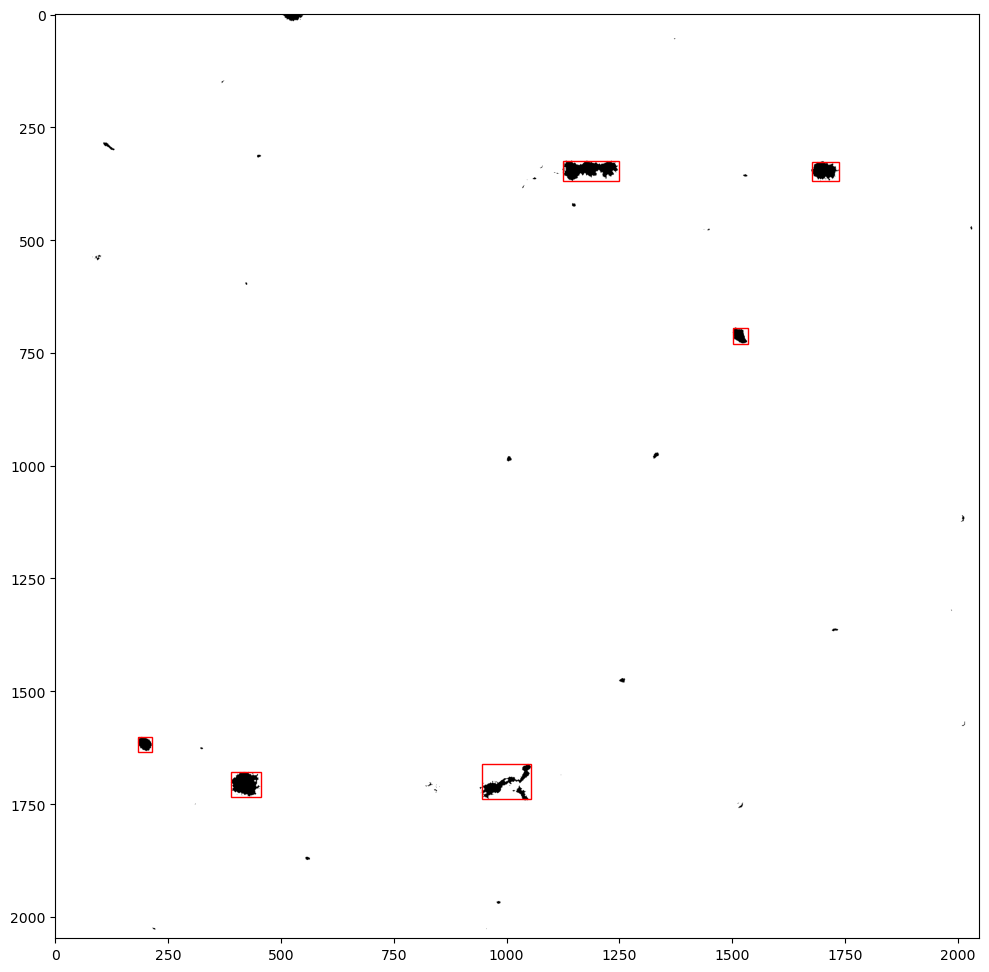

In [49]:
img_example = frames_thresh[70]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas|
    if region.area < 500 or region.area > 8000:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 8000 and region.area < 500:
        continue


    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [50]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            1000 <= region.area <= 10000 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 1000 and region.area < 1000)
            )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


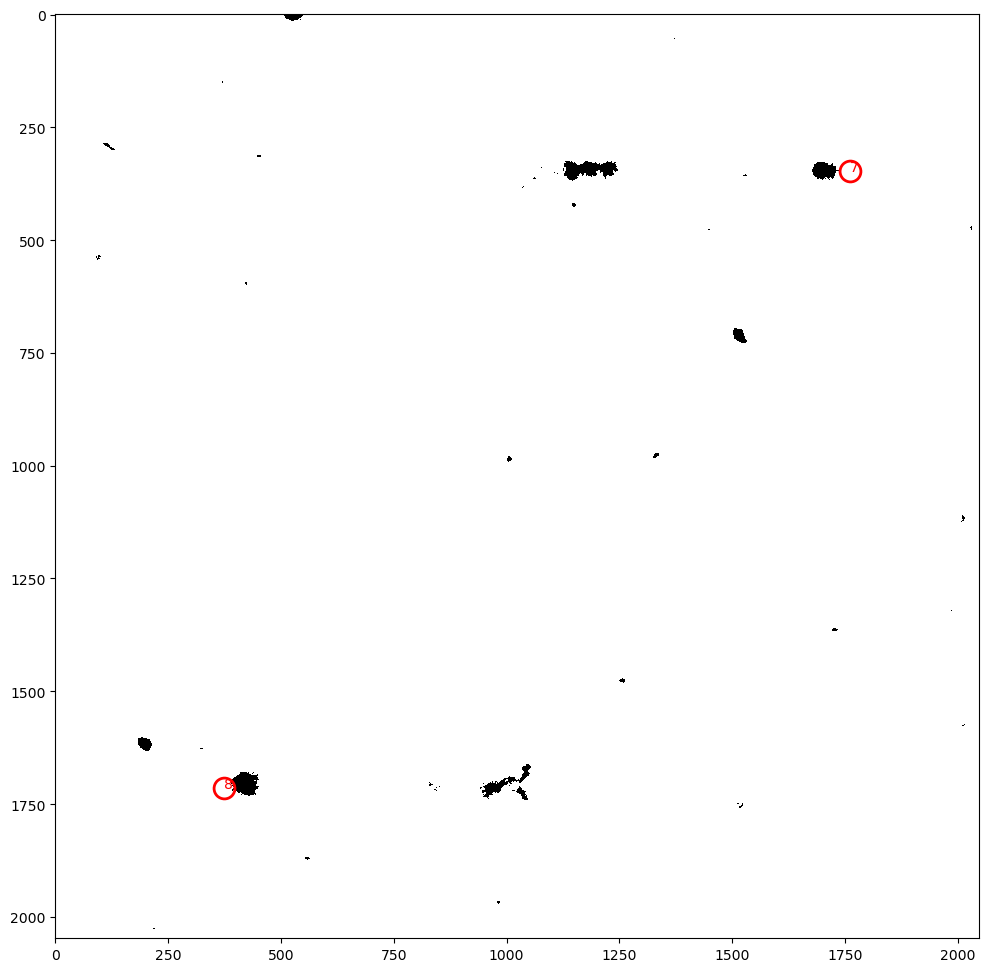

In [51]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(18, features, img_example)


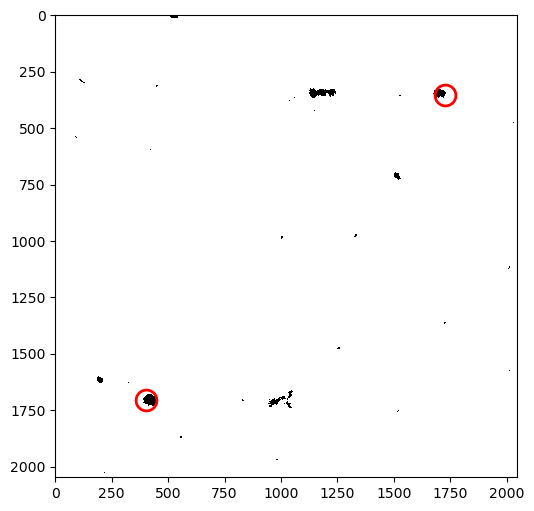

In [52]:
id_example = 50
tp.annotate(features[features.frame==(id_example+1)], img_example);


Frame 223: 3 trajectories present.


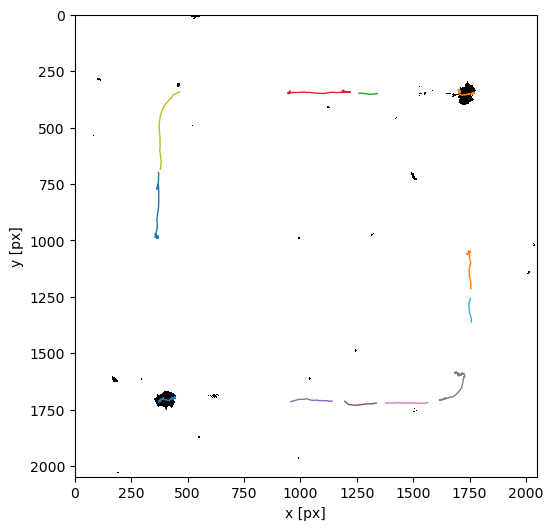

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [53]:
search_range = 40
t = tp.link_df(features, search_range, memory=100)
tp.plot_traj(t, superimpose=frames_thresh[50])

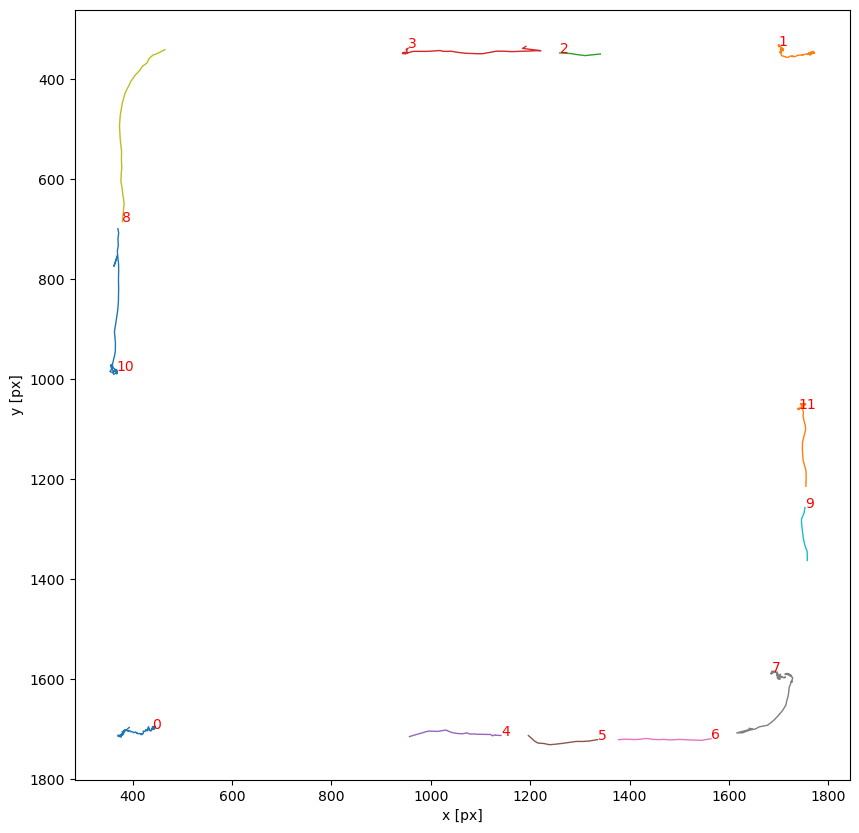

In [54]:
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Then you would use it like this:
plot_trajectory_with_labels(t)


In [56]:
particle_ids = t_filtered['particle'].unique()
selected = t[t['particle'].isin(particle_ids)]


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_10954/3946869110.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  particle_data = np.array(particle_data)


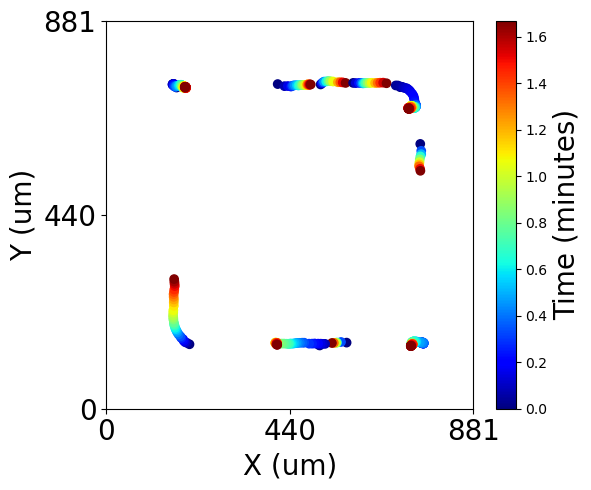

In [57]:
# Ensure data is sorted by frame
selected_sorted = selected.sort_values(by='frame')

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = selected_sorted[selected_sorted['particle'] == particle_id]
    
    # Adjust the time to reflect the "alive time" of each particle
    alive_time = (particle['frame'].values - particle['frame'].values[0]) * 10/60
    
    # Store x, y, and time data for current particle. Convert pixels to um.
    particle_data.append((particle['x'].values * 0.43, particle['y'].values * 0.43, alive_time))
    
 
# Convert list of tuples to numpy array
particle_data = np.array(particle_data)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust as needed to get a square plot

# Loop through each particle and plot its trajectory
for i in range(len(particle_data)):
    sc = ax.scatter(particle_data[i, 0], particle_data[i, 1], c=particle_data[i, 2], cmap='jet')

# Invert y-axis and set plot limits
ax.set_xlim(0, 2048 * 0.43)
ax.set_ylim(0, 2048 * 0.43)
ax.tick_params(axis='both', labelsize=20)


# Set x and y ticks
ax.set_xticks([0, 2048 * 0.43 / 2, 2048 * 0.43])
ax.set_yticks([0, 2048 * 0.43 / 2, 2048 * 0.43])

formatter = ticker.FormatStrFormatter('%.0f')
# Apply the formatter to the x and y axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Set x and y labels
ax.set_xlabel('X (um)', fontsize=20)
ax.set_ylabel('Y (um)', fontsize=20)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Time (minutes)', fontsize=20)

plt.tight_layout()
plt.show()


In [ ]:
# List of groups of particles to merge
merge_groups = [[11, 12, 15], [13, 6, 16]]  # Replace with your own groups

# Make a copy of the dataframe to avoid modifying the original one
df_merged = t.copy()

# Iterate over all groups
for group in merge_groups:
    # Get the target ID (the first one in the group)
    target_id = group[0]
    # Get the IDs to be replaced (all others in the group)
    ids_to_replace = group[1:]
    # Replace all IDs in ids_to_replace with the target ID in the 'particle' column
    for particle_id in ids_to_replace:
        df_merged.loc[df_merged['particle'] == particle_id, 'particle'] = target_id


In [ ]:
# A list of sets of particle IDs that you want to merge
particles_to_merge = [{11, 17, 12, 15}, {13, 6, 16}]

merged_particles = pd.DataFrame(columns=t.columns)

for particle_set in particles_to_merge:
    # Concatenate the trajectories of the particles in the current set
    merged_particle = pd.concat(t[t['particle'] == id] for id in particle_set)
    
    # Remove any duplicate entries
    merged_particle = merged_particle.drop_duplicates(subset=['frame'])
    
    # Assign a new particle ID
    merged_particle['particle'] = max(t['particle']) + 1
    
    # Append the merged particle to the DataFrame of merged particles
    merged_particles = merged_particles.append(merged_particle, ignore_index=True)

# Append the DataFrame of merged particles to the original DataFrame
t = t.append(merged_particles, ignore_index=True)

# Remove the original particles
for particle_set in particles_to_merge:
    t = t[~t['particle'].isin(particle_set)]

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_92020/3508963689.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_particles = merged_particles.append(merged_particle, ignore_index=True)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_92020/3508963689.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_particles = merged_particles.append(merged_particle, ignore_index=True)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_92020/3508963689.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  t = t.append(merged_particles, ignore_index=True)


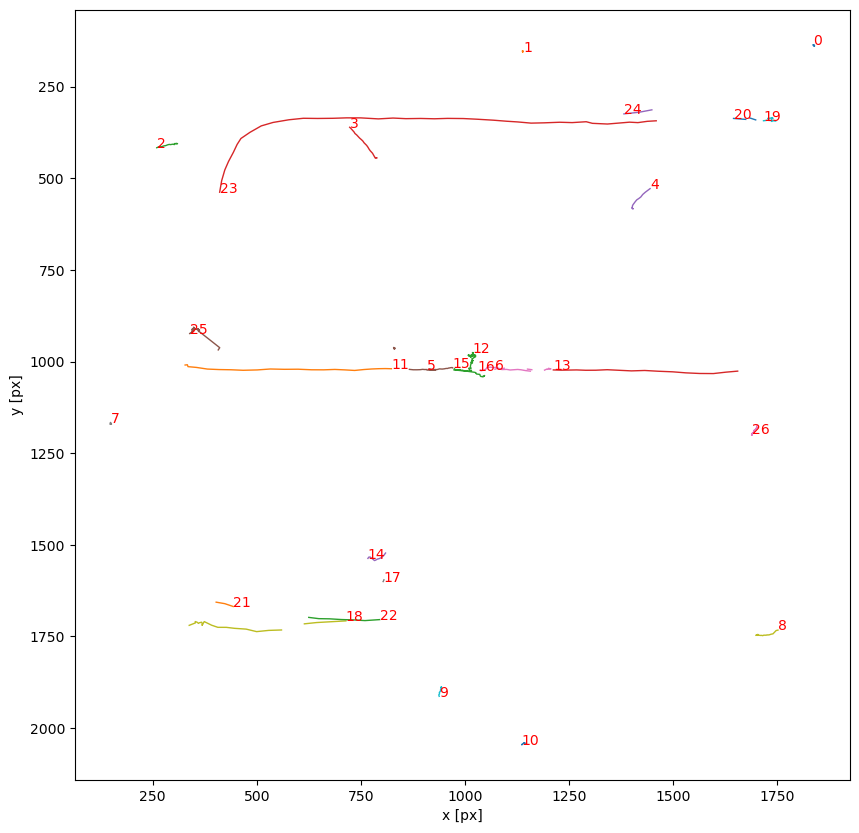

In [ ]:
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Then you would use it like this:
plot_trajectory_with_labels(t)


In [152]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
print(selected)


               y            x  frame  particle
6    1020.070632  1205.643123      0         6
17   1019.996269  1204.235075      1         6
28   1020.444853  1203.540441      2         6
39   1020.176923  1203.880769      3         6
50   1019.374517  1203.173745      4         6
61   1019.987500  1202.508333      5         6
73   1018.195833  1200.916667      6         6
72   1009.594937   327.784810      6        11
85   1020.784553  1200.101626      7         6
84   1008.852632   333.153684      7        11
98   1038.685484  1046.588710      8        12
97   1021.466667  1198.047059      8         6
96   1014.004931   334.723866      8        11
107  1039.450450  1046.166667      9        12
105  1016.122087   354.937183      9        11
106  1020.265217  1197.026087      9         6
116  1023.490000  1190.815000     10         6
114  1020.596683   381.168335     10        11
115  1026.233658  1654.561892     10        13
123  1021.957774   409.302285     11        11
125  1040.872

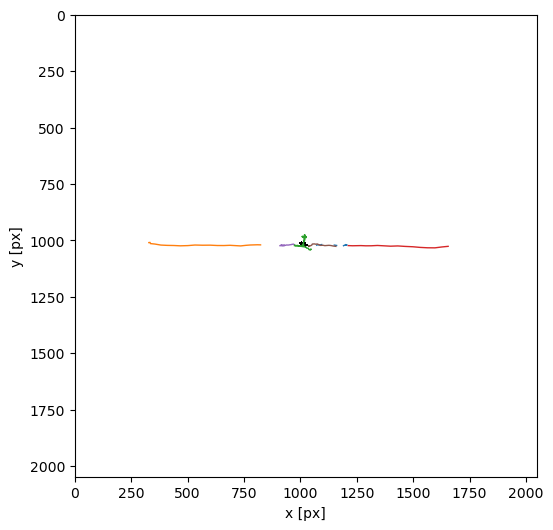

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_92020/1524576735.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  particle_data = np.array(particle_data)


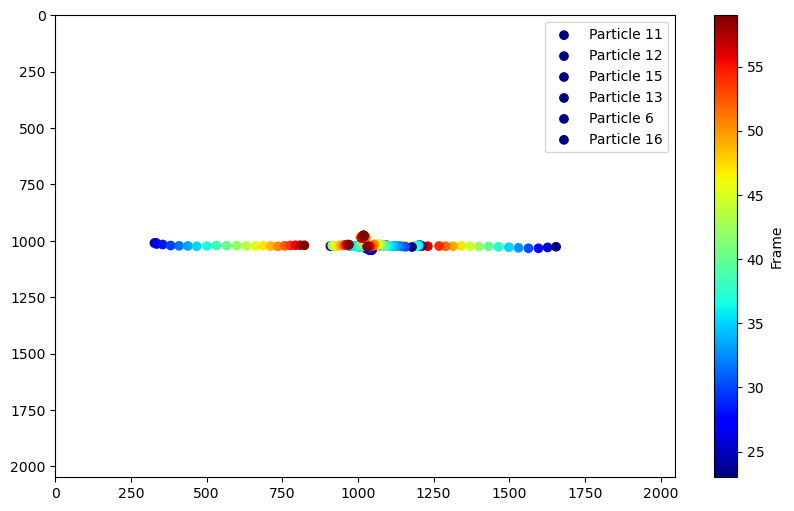

In [140]:
particle_ids = [11, 12, 15, 13, 6, 16]  # Replace with the IDs of the particles you want to plot
selected = t[t['particle'].isin(particle_ids)]
# Filter rows where particle is 24 and index is between 50 and 60
# Print the filtered dataframe
tp.plot_traj(selected, superimpose=frames_thresh[70])

# Ensure data is sorted by frame
selected_sorted = selected.sort_values(by='frame')

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = selected_sorted[selected_sorted['particle'] == particle_id]
    
    # Store x, y, and frame data for current particle
    # If you know the time interval between frames, multiply 'frame' by this interval
    # For example, if each frame is 10 seconds apart, use particle['frame'].values * 10
    particle_data.append((particle['x'].values, particle['y'].values, particle['frame'].values))
    
# Convert list of tuples to numpy array
particle_data = np.array(particle_data)

# Loop through each particle and plot its trajectory
for i in range(len(particle_data)):
    sc = plt.scatter(particle_data[i, 0], particle_data[i, 1], c=particle_data[i, 2], cmap='jet', label=f'Particle {particle_ids[i]}')
plt.colorbar(sc, label='Frame')  # If you converted frames to time, change label to 'Time'

# Invert y-axis and set plot limits
plt.gca().invert_yaxis()
plt.xlim(0, 2048)
plt.ylim(2048, 0)

plt.legend()  # show the legend
plt.show()


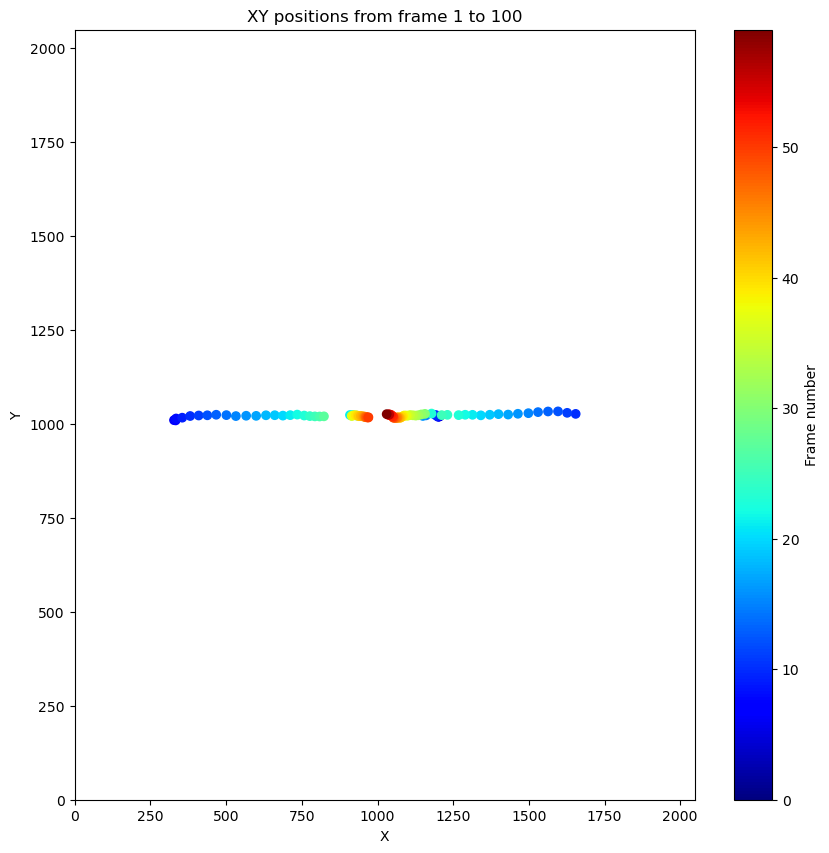

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is called df

# Filter out frames greater than 100
df_filtered = selected[selected['frame'] <= 70]

plt.figure(figsize=(10, 10))

plt.scatter(df_filtered['x'], df_filtered['y'], c=df_filtered['frame'], cmap='jet')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('XY positions from frame 1 to 100')
plt.xlim(0, 2048) # Set the range of x-axis
plt.ylim(0, 2048) # Set the range of y-axis
plt.colorbar(label='Frame number')
plt.show()


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_92020/632803769.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  particle_data = np.array(particle_data)


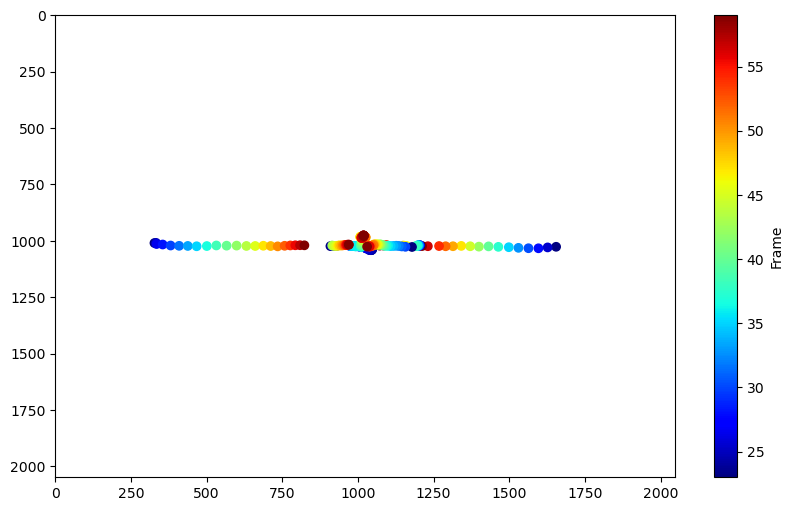

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

particle_ids = [11, 12, 15, 13, 6, 16]  # Replace with the IDs of the particles you want to plot
selected = t[t['particle'].isin(particle_ids)]

# Ensure data is sorted by frame
selected_sorted = selected.sort_values(by='frame')

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = selected_sorted[selected_sorted['particle'] == particle_id]
    
    # Store x, y, and frame data for current particle
    particle_data.append((particle['x'].values, particle['y'].values, particle['frame'].values))
    
# Convert list of tuples to numpy array
particle_data = np.array(particle_data)

# Loop through each particle and plot its trajectory
for i in range(len(particle_data)):
    plt.scatter(particle_data[i, 0], particle_data[i, 1], c=particle_data[i, 2], cmap='jet')

plt.colorbar(label='Frame')

# Invert y-axis and set plot limits
plt.gca().invert_yaxis()
plt.xlim(0, 2048)
plt.ylim(2048, 0)

plt.show()


In [139]:
print(selected_sorted)

               y            x  frame  particle  frame_diff   time
6    1020.070632  1205.643123      0         6         0.0    0.0
17   1019.996269  1204.235075      1         6         1.0    1.0
28   1020.444853  1203.540441      2         6         1.0    2.0
39   1020.176923  1203.880769      3         6         1.0    3.0
50   1019.374517  1203.173745      4         6         1.0    4.0
61   1019.987500  1202.508333      5         6         1.0    5.0
73   1018.195833  1200.916667      6         6         1.0    6.0
72   1009.594937   327.784810      6        11         0.0    0.0
85   1020.784553  1200.101626      7         6         1.0    7.0
84   1008.852632   333.153684      7        11         1.0    1.0
97   1021.466667  1198.047059      8         6         1.0    8.0
96   1014.004931   334.723866      8        11         1.0    2.0
98   1038.685484  1046.588710      8        12         0.0    0.0
107  1039.450450  1046.166667      9        12         1.0    1.0
105  1016.

/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_52320/4068178700.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  particle_data = np.array(particle_data)


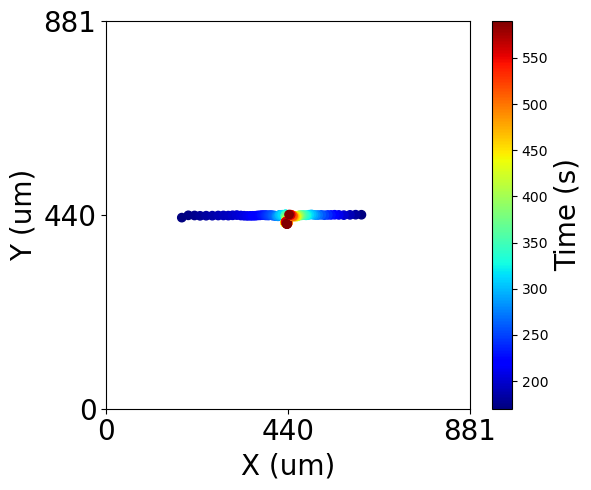

In [128]:
import matplotlib.ticker as ticker

# Ensure data is sorted by frame
selected_sorted = selected.sort_values(by='frame')

# Initialize empty list for storing particle data
particle_data = []

# Loop through each particle ID
for particle_id in particle_ids:
    # Filter for current particle ID
    particle = selected_sorted[selected_sorted['particle'] == particle_id]
    
    # Store x, y, and time data for current particle. Convert pixels to um.
    particle_data.append((particle['x'].values * 0.43, particle['y'].values * 0.43, particle['frame'].values * 10))
    
# Convert list of tuples to numpy array
particle_data = np.array(particle_data)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust as needed to get a square plot

# Loop through each particle and plot its trajectory
for i in range(len(particle_data)):
    sc = ax.scatter(particle_data[i, 0], particle_data[i, 1], c=particle_data[i, 2], cmap='jet')

# Invert y-axis and set plot limits
ax.set_xlim(0, 2048 * 0.43)
ax.set_ylim(0, 2048 * 0.43)
ax.tick_params(axis='both', labelsize=20)


# Set x and y ticks
ax.set_xticks([0, 2048 * 0.43 / 2, 2048 * 0.43])
ax.set_yticks([0, 2048 * 0.43 / 2, 2048 * 0.43])

formatter = ticker.FormatStrFormatter('%.0f')
# Apply the formatter to the x and y axes
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

# Set x and y labels
ax.set_xlabel('X (um)', fontsize=20)
ax.set_ylabel('Y (um)', fontsize=20)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Time (s)', fontsize=20)

plt.tight_layout()
plt.show()


# second panel

In [129]:
# load tiff stake with pims. Notice here I only have two channels, gfp and cy5
#Burst /Volumes/SL_2023/0313/droplet_different_low_MT_6_8_2_burst

frames = pims.ImageSequence('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local to global pre-print/data/fig_4/local_move/*.tif')




Frame([[ 82,  85,  90, ...,  87,  85,  79],
       [101,  98,  95, ...,  92,  99,  99],
       [ 97, 101, 104, ..., 103, 104,  98],
       ...,
       [ 94,  99, 102, ...,  99, 100, 101],
       [ 92,  99, 103, ..., 100,  98,  98],
       [ 98, 105, 109, ..., 101,  97,  94]], dtype=uint8)
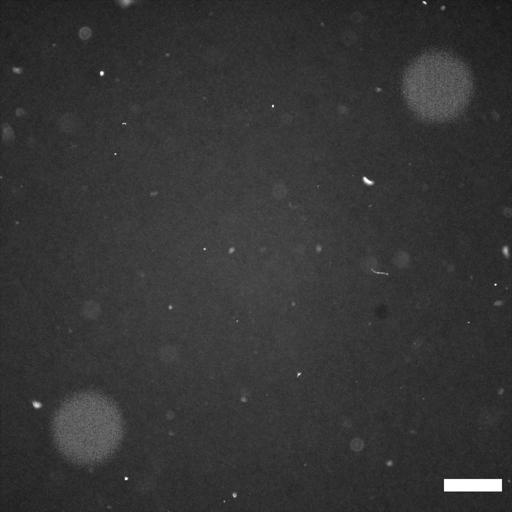

In [130]:
bf_frames = frames
bf_frames[1]

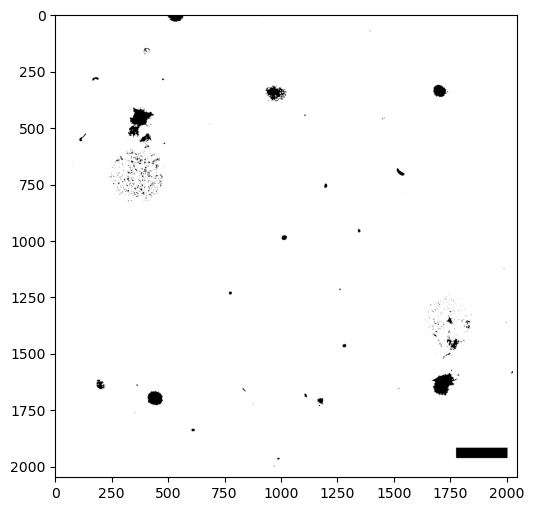

In [151]:
from skimage import filters, util
from scipy import ndimage
import numpy as np

def create_pipeline():
    frame_counter = {'count': 0}  # use a dict to make it mutable inside the nested function

    @pims.pipeline
    def preprocess_foam(img):
        """
        Apply image processing functions to return a binary image
        """
        # Apply thresholds
        percentile = 97 if frame_counter['count'] < 29 else 97  # adjust the percentile based on the frame number
        threshold_value = np.percentile(img, percentile)  # calculate the percentile
        idx = img < threshold_value  # consider pixels brighter than the percentile
        idx2 = img >= threshold_value  # consider pixels not brighter than the percentile
        img[idx] = 255
        img[idx2] = 0
        img = ndimage.binary_dilation(img)
        img = ndimage.binary_dilation(img)

        # increment the frame counter
        frame_counter['count'] += 1

        return util.img_as_int(img)
    
    return preprocess_foam

preprocess_foam = create_pipeline()



frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[120]);

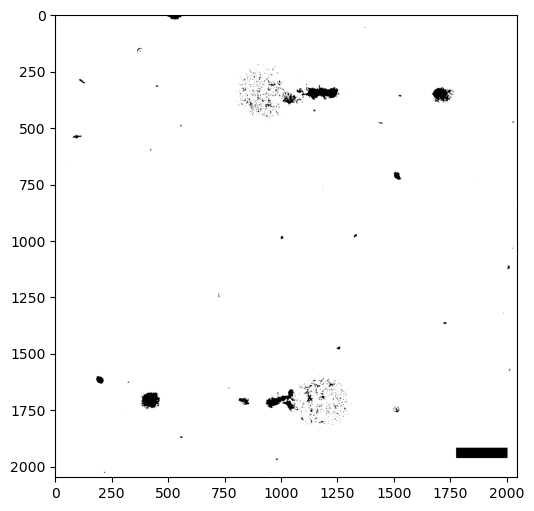

In [154]:
plt.imshow(frames_thresh[70]);

Found 939 features


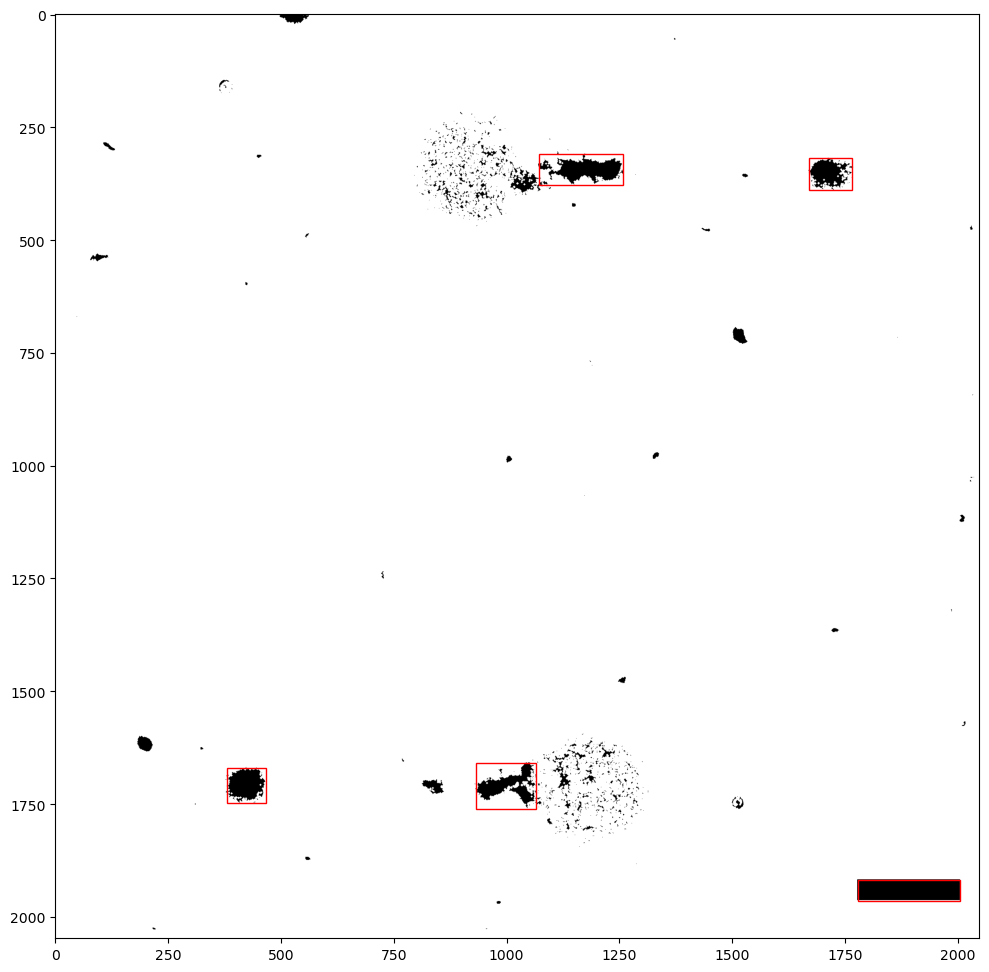

In [155]:
img_example = frames_thresh[70]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 2000 or region.area > 50000:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 50000 and region.area < 2000:
        continue


    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [156]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            2000 <= region.area <= 50000 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 50000 and region.area < 2000)
            )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


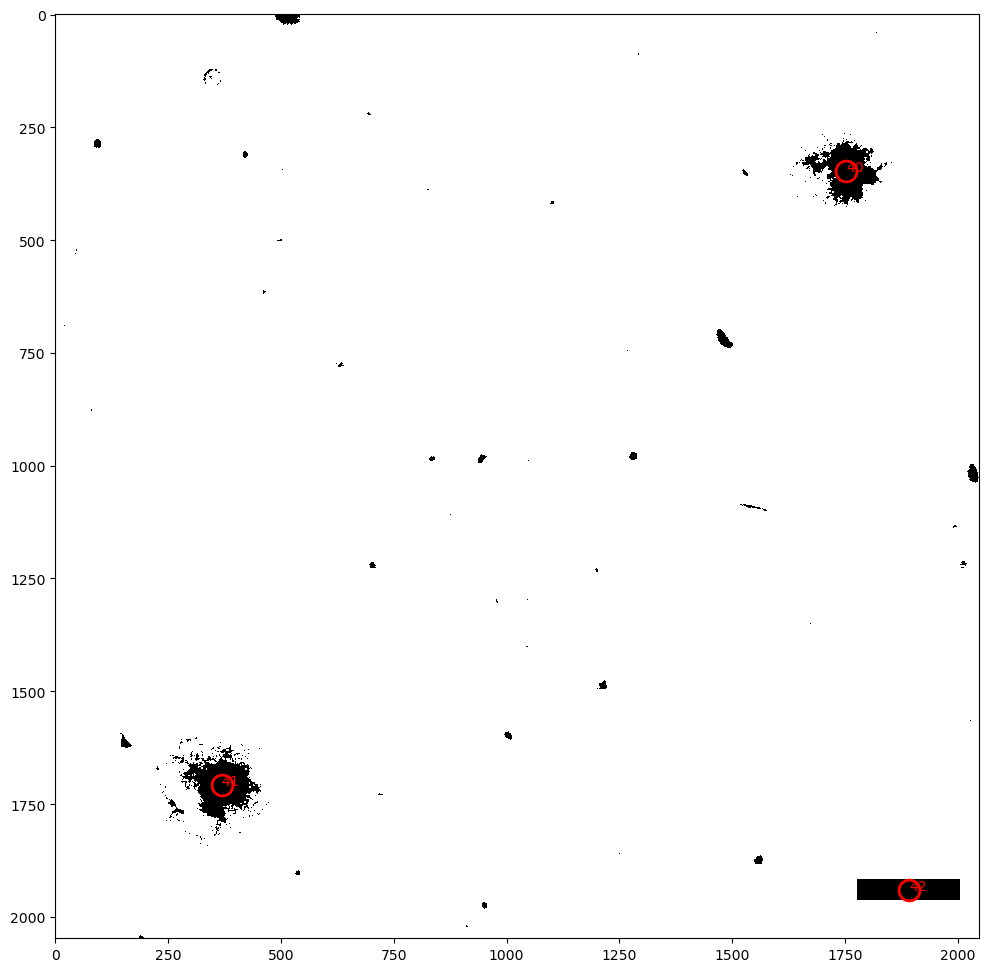

In [145]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(18, features, img_example)


Frame 223: 1 trajectories present.


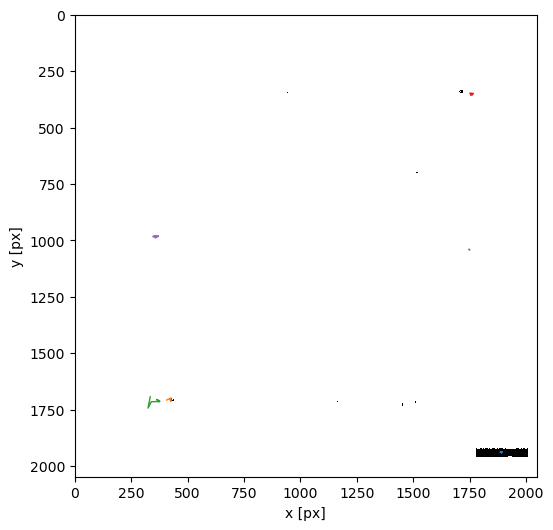

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [149]:
search_range = 100
t = tp.link_df(features, search_range, memory=20)
tp.plot_traj(t, superimpose=frames_thresh[100])